### ECON 499 Data Preparation
   - By Sheldon Birkett

In [2]:
!pip install folium geopy
!pip install geojson
!pip install git+https://github.com/python-visualization/folium

  Cloning https://github.com/python-visualization/folium to c:\users\sheld\appdata\local\temp\pip-req-build-73f3faz5
  Created wheel for folium: filename=folium-0.0.0-py2.py3-none-any.whl size=95360 sha256=eed63f4b2611d873d8da2957b02eff31f5dde1a42bc42ad385068afe4f786cb6
  Stored in directory: C:\Users\sheld\AppData\Local\Temp\pip-ephem-wheel-cache-3vqlr3sv\wheels\c7\41\34\51d4fc16546a2a77c5ca875d9232ebf13d902dd87615be512c
Successfully built folium


  Running command git clone -q https://github.com/python-visualization/folium 'C:\Users\sheld\AppData\Local\Temp\pip-req-build-73f3faz5'


In [3]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

'apt' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


  Cloning git://github.com/geopandas/geopandas.git to c:\users\sheld\appdata\local\temp\pip-req-build-teh7jrx7
  Created wheel for geopandas: filename=geopandas-0.8.0+98.gefea225-py2.py3-none-any.whl size=981829 sha256=a9f7eb0ebd18e097bfb506d34a26c708b70c9c93df4f02f04bd1e1ff38486d76
  Stored in directory: C:\Users\sheld\AppData\Local\Temp\pip-ephem-wheel-cache-3o82t1e0\wheels\cf\3e\0b\6475054094c2b1ea054158ac1fdcf749fb92f5b512377e4cf8
Successfully built geopandas


  Running command git clone -q git://github.com/geopandas/geopandas.git 'C:\Users\sheld\AppData\Local\Temp\pip-req-build-teh7jrx7'


Wall time: 43.6 s


In [4]:
!pip install selenium

In [5]:
!pip install topojson

In [6]:
import folium
from folium.features import DivIcon
import geojson

In [7]:
import numpy as np
import pandas as pd

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

In [9]:
import geopandas as gpd
from shapely import wkt
import shapely as sh

In [10]:
from itertools import chain

In [11]:
import topojson as tp

In [12]:
from geopy.distance import great_circle as distance
from geopy.point import Point as Point
from math import sin, cos, atan2, sqrt, degrees, radians, pi

In [173]:
def import_csv(content):
    """Read in csv as a dataframe"""
    acs_data = pd.read_csv(content, encoding= 'unicode_escape')
    return acs_data

In [174]:
def midpoint(a, b):
    a_lat, a_lon = radians(a.latitude), radians(a.longitude)
    b_lat, b_lon = radians(b.latitude), radians(b.longitude)
    delta_lon = b_lon - a_lon
    B_x = cos(b_lat) * cos(delta_lon)
    B_y = cos(b_lat) * sin(delta_lon)
    mid_lat = atan2(
        sin(a_lat) + sin(b_lat),
        sqrt(((cos(a_lat) + B_x) ** 2 + B_y ** 2))
    )
    mid_lon = a_lon + atan2(B_y, cos(a_lat) + B_x)
    # Normalise
    mid_lon = (mid_lon + 3 * pi) % (2 * pi) - pi

    return Point(latitude=degrees(mid_lat), longitude=degrees(mid_lon))

In [175]:
def get_line_midpoint(line):
    a = Point(line[0])
    b = Point(line[1])

    return midpoint(a,b)

In [176]:
def calculate_dist_to_line(line_a_lat, line_a_lng, line_b_lat, line_b_lng, point_object):
    a = Point(latitude=line_a_lat, longitude=line_a_lng)
    b = Point(latitude=line_b_lat, longitude=line_b_lng)
    dist = distance(midpoint(a, b), point_object)
    return dist

In [177]:
def get_min_distance_to_arr(arr_coords, point_object, unit='m'):
    min_dist = 999999
    line=[]
    for i, _ in enumerate(arr_coords):
        if i + 1 < len(arr_coords):
            dist = calculate_dist_to_line(
                line_a_lat=arr_coords[i][1],
                line_a_lng=arr_coords[i][0],
                line_b_lat=arr_coords[i + 1][1],
                line_b_lng=arr_coords[i + 1][0],
                point_object=point_object
            )
            if dist < min_dist:
                min_dist = dist
                line = [(arr_coords[i][1], arr_coords[i][0]), (arr_coords[i + 1][1], arr_coords[i + 1][0])]
        else:
            dist = calculate_dist_to_line(
                line_a_lat=arr_coords[i][1],
                line_a_lng=arr_coords[i][0],
                line_b_lat=arr_coords[0][1],
                line_b_lng=arr_coords[0][0],
                point_object=point_object
            )
            if dist < min_dist:
                min_dist = dist
                line = [(arr_coords[i][1], arr_coords[i][0]), (arr_coords[0][1], arr_coords[0][0])]

    if unit == 'm':
        return min_dist.m, line
    elif unit == 'km':
        return min_dist.km, line
    else:
        return min_dist, line

In [178]:
def to_coords(multipolygon):
    for polygon in multipolygon:
        yield from polygon.exterior.coords[:-1]
        yield from chain.from_iterable(interior.coords[:-1] for interior in polygon.interiors)

In [179]:
def strip_dict_keys_values(d):
    """To remove white-space in keys and values in dictionary"""
    def strip_list(l):
        return [strip_dict_keys_values(x)
                if isinstance(x, dict) else strip_list(x)
                if isinstance(x, list) else clean(x) for x in l]

    def clean(value):
        if isinstance(value, str):
            return value.strip()
        return value

    return {key.strip(): strip_dict_keys_values(value)
            if isinstance(value, dict) else strip_list(value)
            if isinstance(value, list) else clean(value)
            if value is None else clean(value)
            for key, value in d.items()}

Import Wildfire Perimeter Data, To GeoJSON file

In [20]:
wildfire_perimeters = gpd.read_file(r"C:\Users\sheld\Downloads\THESIS_MAPS_\Historic_GeoMAC_Perimeters_Combined_2000-2018-shp")
wildfire_perimeters.to_file('wildfire_perimeters.geojson', driver='GeoJSON')

In [21]:
wildfire_perimeters_2015 = wildfire_perimeters[wildfire_perimeters["fireyear"] == 2015]
Test_fire = wildfire_perimeters_2015[(wildfire_perimeters_2015["incidentna"]== "Rough") | (wildfire_perimeters_2015["incidentna"]=="Valley") | (wildfire_perimeters_2015["incidentna"]=="River Complex")| (wildfire_perimeters_2015["incidentna"]=="Made River Complex")| (wildfire_perimeters_2015["incidentna"]=="Butte")]

In [22]:
poi_name = 'Trinity County Blk 1'
poi = [41.0171618, -122.6402253] #Lat, Long 

In [23]:
# Map it
m = folium.Map(location=poi, zoom_start=9, tiles='https://api.mapbox.com/styles/v1/sheldonnb/ckkz0oxri7j6w1ap5zcwzgu8m/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoic2hlbGRvbm5iIiwiYSI6ImNra3owZzB5ajBidDQycHBsZGY1Zm1vYnAifQ.IiKmYf729J6mYBynizPi2g', attr = 'XXX Mapbox Attribution')
# Display Wildfire Perimeters
folium.GeoJson(data = Test_fire["geometry"], name="geojson").add_to(m)

# Display POI
folium.Marker(location=poi,popup="<b>Block Group 1, Census Tract 1.01,Trinity County</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)


In [24]:
m #produce map of single poi and wildfire perimeter

Find Min Distance to a Fire Perimeter for One Point

In [25]:
points = list(to_coords(Test_fire["geometry"].iloc[1]))

In [26]:
coords = points

In [27]:
p = Point(latitude=poi[0],longitude=poi[1])

In [28]:

dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
line_midpoint = get_line_midpoint(line)

In [29]:
m = folium.Map(location=poi, zoom_start=12, tiles='CartoDB dark_matter')


# Display POI
folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
# Display POI Name
folium.map.Marker(location=poi, icon=DivIcon(
    icon_size=(150, 36),
    icon_anchor=(0, 0),
    html='<div style="font-size: 18pt; color: red">{}</div>'.format(poi_name)
)).add_to(m)

for i, _ in enumerate(coords):
    if i+1 < len(coords):
        folium.PolyLine(locations=[(coords[i][1],coords[i][0]),(coords[i+1][1],coords[i+1][0])], color='blue').add_to(m)
    else:
        folium.PolyLine(locations=[(coords[i][1], coords[i][0]), (coords[0][1], coords[0][0])],
                        color='blue').add_to(m)

folium.PolyLine(locations=line, color='red').add_to(m)
folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='red').add_to(m)
folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
folium.map.Marker(location=[new_line_mp.latitude,new_line_mp.longitude], icon=DivIcon(
    icon_size=(150, 36),
    icon_anchor=(0, 0),
    html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
)).add_to(m)

In [30]:
#m #displays min dist to polygon

Find the Min Distance for Many Wildfire Perimeters

In [31]:
m = folium.Map(location=poi, zoom_start=12, tiles='CartoDB dark_matter')

# Display POI
folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
# Display POI Name
folium.map.Marker(location=poi, icon=DivIcon(
    icon_size=(150, 36),
    icon_anchor=(0, 0),
    html='<div style="font-size: 18pt; color: red">{}</div>'.format(poi_name)
)).add_to(m)

# Display Arrondissements
folium.GeoJson(Test_fire).add_to(m) #Note change to Test_fire for example
# Display Arrondissements Numbers
# for arrond in data['features']:
#     loc = arrond['properties']['geom_x_y']
#     nr = arrond['properties']['c_ar']
#     folium.map.Marker(location=loc, icon=DivIcon(
#         icon_size=(150, 36),
#         icon_anchor=(0, 0),
#         html='<div style="font-size: 15pt; color:rgb(41,111,255)">{}</div>'.format(str(nr))
#     )).add_to(m)

# for arrond in data['features']:

#     coords = arrond['geometry']['coordinates'][0]
#     p = Point(latitude=poi[0],longitude=poi[1])
#     dist, line = fu.get_min_distance_to_arr(arr_coords=coords,point_object=p)
#     line_midpoint = fu.get_line_midpoint(line)

    # for i, _ in enumerate(coords):
    #     if i+1 < len(coords):
    #         folium.PolyLine(locations=[(coords[i][1],coords[i][0]),(coords[i+1][1],coords[i+1][0])], color='blue').add_to(m)
    #     else:
    #         folium.PolyLine(locations=[(coords[i][1], coords[i][0]), (coords[0][1], coords[0][0])],
    #                         color='blue').add_to(m)

    # folium.PolyLine(locations=line, color='red').add_to(m)
    # folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='red').add_to(m)
    # folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

    # new_line_mp = fu.get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
    # folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
    #     icon_size=(150, 36),
    #     icon_anchor=(0, 0),
    #     html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
    # )).add_to(m)

In [32]:
#m #plotted a few wildfire perimeters and a signle poi

In [33]:
points = []
for i in range(len(Test_fire["geometry"])): 
  points.append(list(to_coords(Test_fire["geometry"].iloc[i]))) #gives list of list of coords for each wildfire perimeter

In [34]:
distances = []
for i in range(len(points)):
  coords = points[i]
  p = Point(latitude=poi[0],longitude=poi[1])
  dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
  line_midpoint = get_line_midpoint(line)

  distances.append(dist) 

  folium.PolyLine(locations=line, color='red').add_to(m)
  folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='red').add_to(m)
  folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

  new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
  folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
        icon_size=(150, 36),
        icon_anchor=(0, 0),
        html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
    )).add_to(m)

In [35]:
#m #shows plot of minimum distance to single poi and a few perimeters with min dist in meters

Now Calculate Min Distances to Wildfires for Multiple Homes/POI's

In [36]:
ACS5_2014_bg0 = import_csv(r"C:\Users\sheld\Documents\Thesis_Data_Full_United_States\merged_data_with_block_groups\ACS5_2014_bg.csv")

In [37]:
ACS5_2014_bg0["POIs"] = list(zip(ACS5_2014_bg0.INTPTLAT, ACS5_2014_bg0.INTPTLON)) #coordinates for homes/center of block groups 

missing house prices for 8532 homes, will drop. 

In [38]:
missing = ACS5_2014_bg0.loc[ACS5_2014_bg0["ABITE001"].isnull()].index.tolist() #missing median home prices for 8532 observations
ACS5_2014_bg0 = ACS5_2014_bg0.drop(missing).reset_index() 

In [39]:
West_US = [40.117651, -115.158374] #random location in middle of western united states. a

In [40]:
ACS5_2014_Test = ACS5_2014_bg0.iloc[::2000, :].drop(columns = ["Unnamed: 0"]).reset_index() #select every 2000th row just as a sample.

In [41]:
my_tile = 'https://api.mapbox.com/styles/v1/sheldonnb/ckkz0oxri7j6w1ap5zcwzgu8m/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoic2hlbGRvbm5iIiwiYSI6ImNra3owZzB5ajBidDQycHBsZGY1Zm1vYnAifQ.IiKmYf729J6mYBynizPi2g'

In [42]:
m = folium.Map(location=West_US, zoom_start=12, tiles= my_tile, attr = 'XXX Mapbox Attribution')

# Display Wildfires
folium.GeoJson(Test_fire).add_to(m) #Note change to Test_fire for example

min_distances = []
points = []
for i in range(len(Test_fire["geometry"])): 
    points.append(list(to_coords(Test_fire["geometry"].iloc[i]))) #gives list of list of coords for each wildfire perimeter

for j in range(len(ACS5_2014_Test["POIs"])): 
    # Display POI for center of block group i.
    poi = ACS5_2014_Test["POIs"][j] 
    #folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
    pop = ACS5_2014_Test["NAME_E"][j]
    folium.Marker(location=poi,popup=f"<b>{pop}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)
    # Display POI Name
    # folium.map.Marker(location=poi, icon=DivIcon(
    #     icon_size=(150, 36),
    #     icon_anchor=(0, 0),
    #     html='<div style="font-size: 18pt; color: red">{}</div>'.format(poi_name)
    # )).add_to(m)
    distances = []
    lines = []
    for i in range(len(points)):
        coords = points[i]
        p = Point(latitude=poi[0],longitude=poi[1])
        dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
        line_midpoint = get_line_midpoint(line)
        distances.append(dist)
        lines.append(line)
        folium.PolyLine(locations=line, color='#AD44DA').add_to(m)
        folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='#AD44DA').add_to(m)
        folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)
        
        new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
        folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
              icon_size=(150, 36),
              icon_anchor=(0, 0),
              html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
          )).add_to(m)
        
    min_distances.append(min(distances))

In [43]:
#m.save('distance_map.html') #produce map of many minimum distances from many poi's to many wildfire perimeters

## Produce Map of All Wildfire from 2010 to 2018

In [44]:
#get fire years of interest which covers acs 2010-2019 dataframes
fire_years = list(range(2010,2019))
frames = []
for i in range(len(fire_years)):
    wildfires = wildfire_perimeters[wildfire_perimeters["fireyear"] == fire_years[i]]
    frames.append(wildfires)

wildfires_2015_to_2018 = pd.concat(frames,join='inner', ignore_index=True)

In [45]:
import branca.colormap as cm

fire_min = wildfires_2015_to_2018['gisacres'].min()
fire_max = wildfires_2015_to_2018['gisacres'].max()

linear = cm.linear.OrRd_05.scale(fire_min, fire_max)

In [46]:
linear

In [47]:
def reversed_colormap(existing):
    return cm.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax)

linear = reversed_colormap(linear)

In [48]:
linear

In [49]:
m = folium.Map(location=[38.5, -113.158374], zoom_start=5.49, tiles= my_tile, attr = 'XXX Mapbox Attribution', prefer_canvas=True)


#fire_dict = dict(zip(wildfires_2015_to_2018['incidentna'], wildfires_2015_to_2018['gisacres']))
    
map_colors = lambda x: {
    'fillColor': linear(x['properties']['gisacres']),
    'color': 'black',
    'weight': 0.25,
    'fillOpacity': 0.5
}
    
#Display Wildfires
folium.GeoJson(
    wildfires_2015_to_2018,
    name = 'Wildfires',
    style_function = map_colors
).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

linear = linear.to_step(index=[0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000, 663000])
linear.caption = 'Number of Acres Burned by Wildfire'
linear.add_to(m)

In [50]:
#m.save('map_of_all_fires3.html')

## Create Map of All Wildfire Perimeters

In [51]:
from shapely.geometry import box

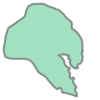

In [52]:
h = wildfires_2015_to_2018["geometry"][7]
h

In [53]:
b = h.bounds

In [54]:
b

(-112.26487454499994,
 42.94214678000003,
 -112.25630167199995,
 42.95218907000003)

In [55]:
bb = box(-146.35855885399997, 64.76123059500003, -146.22002814499996, 64.82435905700004)

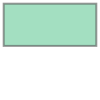

In [56]:
bb

In [58]:
boun = []
for i in range(len(wildfires_2015_to_2018["geometry"])):
    l = wildfires_2015_to_2018["geometry"][i].bounds
    boun.append(l)

In [59]:
from shapely import geometry

In [60]:
box_list = []
for i in range(len(boun)):
    a = boun[i][0]
    b = boun[i][1]
    c = boun[i][2]
    d = boun[i][3]
    m = box(a,b,c,d)
    box_list.append(geometry.Polygon(list(m.exterior.coords)))

In [61]:
wildfires_2015_to_2018["boxgeo"] = box_list

In [105]:
wildfires_2015_to_2018_box_geo = wildfires_2015_to_2018[["boxgeo","gisacres","fireyear","state"]]

In [106]:
wildfires_2015_to_2018_box_geo = gpd.GeoDataFrame(wildfires_2015_to_2018_box_geo, geometry='boxgeo')
#wildfires_2015_to_2018_box_geo.to_file('wildfires_2015_to_2018_box_geo.geojson', driver='GeoJSON')

In [107]:
wildfires_2015_to_2018_box_geo = wildfires_2015_to_2018_box_geo.set_crs("EPSG:4326") #set projection. 
wildfires_2015_to_2018_box_geo = wildfires_2015_to_2018_box_geo.set_crs(epsg=4326)

In [65]:
m = folium.Map(location=[38.5, -113.158374], zoom_start=5.49, tiles= my_tile, attr = 'XXX Mapbox Attribution', prefer_canvas=True)


#fire_dict = dict(zip(wildfires_2015_to_2018['incidentna'], wildfires_2015_to_2018['gisacres']))
    
map_colors = lambda x: {
    'fillColor': linear(x['properties']['gisacres']),
    'color': 'black',
    'weight': 0.25,
    'fillOpacity': 0.5
}
    
#Display Wildfires
folium.GeoJson(
    wildfires_2015_to_2018_box_geo,
    name = 'Wildfires',
    style_function = map_colors
).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

linear = linear.to_step(index=[0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000, 663000])
linear.caption = 'Number of Acres Burned by Wildfire'
linear.add_to(m)

AttributeError: 'StepColormap' object has no attribute 'to_step'

In [ ]:
#m.save('boxgeo.html')

test getting minimum distances for simplified shapes (squares/rectangles)

In [89]:
ACS5_2014_WEST = ACS5_2014_bg0[(ACS5_2014_bg0["STATE"] == "Arizona") | (ACS5_2014_bg0["STATE"] == "California")|(ACS5_2014_bg0["STATE"] == "Colorado") | (ACS5_2014_bg0["STATE"] == "Idaho")|(ACS5_2014_bg0["STATE"] == "Nebraska")| (ACS5_2014_bg0["STATE"] == "New Mexico")|(ACS5_2014_bg0["STATE"] == "Oklahoma")| (ACS5_2014_bg0["STATE"] == "Oregon")|(ACS5_2014_bg0["STATE"] == "South Dakota")|(ACS5_2014_bg0["STATE"] == "Texas")|(ACS5_2014_bg0["STATE"] == "Kansas")| (ACS5_2014_bg0["STATE"] == "Wyoming")|(ACS5_2014_bg0["STATE"] == "Montana")|(ACS5_2014_bg0["STATE"] == "North Dakota")|(ACS5_2014_bg0["STATE"] == "Utah")|(ACS5_2014_bg0["STATE"] == "Nevada")| (ACS5_2014_bg0["STATE"] == "Washington")]

In [91]:
ACS5_2014_WEST = ACS5_2014_WEST.drop(columns=["Unnamed: 0"]).reset_index()

In [95]:
wildfires_2015_box_geo = wildfires_2015_to_2018_box_geo[wildfires_2015_to_2018_box_geo["fireyear"] == 2015]

In [99]:
%%time
## Min Distance Calculation for Wildfire Year 2015. 

##m = folium.Map(location=West_US, zoom_start=8, tiles='Stamen Terrain') # double "##" is older code not used in loop distance calculation

##Display Wildfires
##folium.GeoJson(wildfire_perimeters_2015).add_to(m) #Note change to Test_fire for example

min_distances = []
points = []
#make all the lists for each state you will look at
for i in range(len(wildfires_2015_box_geo["boxgeo"])):
  ##poly = wildfire_perimeters_2015["geometry"].iloc[i]
  ##if poly.geom_type == 'MultiPolygon':
  ##   points.append(list(to_coords(wildfire_perimeters_2015["geometry"].iloc[i]))) #gives list of list of coords for each wildfire perimeter Multipolygon
  ##elif poly.geom_type == 'Polygon':
    #if fire in california append to california list else if fire in texas append to texas list etc etc
    points.append(get_coords_from_polygon(wildfires_2015_box_geo["boxgeo"].iloc[i])) #gives list of list of coords for each wildfire perimeter Polygon

for j in range(len(ACS5_2014_WEST["POIs"])): 
    ##Display POI for center of block group i.
    poi = ACS5_2014_WEST["POIs"][j] 

  ##folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
  #pop = ACS5_2014_bg0["NAME_E"][j]
  #price = ACS5_2014_bg0["ABITE001"][j]
  ##folium.Marker(location=poi,popup=f"<b>{pop},${price:.2f}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)
  ##Display POI Name
#if house in california loop through california, nevada, arizona, oregon
    distances = []
    lines = []
    for i in range(len(points)):
        coords = points[i]
        p = Point(latitude=poi[0],longitude=poi[1])
        dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
        line_midpoint = get_line_midpoint(line)
        
        distances.append(dist)
        lines.append(line)

    ##folium.PolyLine(locations=line, color='#AD44DA').add_to(m)
    ##folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='#AD44DA').add_to(m)
    ##folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

    #new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
    ##folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
    ##       icon_size=(150, 36),
    ##       icon_anchor=(0, 0),
    ##      html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
    ##   )).add_to(m)
      
    min_distances.append(min(distances)) #min_distances_california
    #if house in texas etc etc loop through texas and neighboring stats -> min_distances_texas
    
    #at the end after you've done each state append together all your min_distances_{state} lists

KeyboardInterrupt: 

Will Plot Entire Dataframe and All Fires for 2015

In [66]:
#get coords for polygon and multipolygon as previous get coord function only worked on polygons. 
def get_coords_from_polygon(shape):
    coords = set()

    if isinstance(shape, sh.geometry.Polygon):
        coords.update(shape.exterior.coords[:-1])
        for linearring in shape.interiors:
            coords.update(linearring.coords[:-1])
    elif isinstance(shape, sh.geometry.MultiPolygon):
        for polygon in shape:
            coords.update(get_coords_from_polygon(polygon))

    return list(coords)

## Minimum Distance by Looping Over State and Nearby States, Not Including Alaska/Hawaii and most eastern states (Old Method Took Too Long)
   - Run loop below for each year and save as a csv to computer.
   - ``wildfires_2015_to_2018_box_geo[wildfires_2015_to_2018_box_geo["fireyear"] == 2010]`` change year `20**` for each iteration to get columns for each year in the dataframe.
   - Columns are indexed in tuples with `ACS5_2014_WEST["GISJOIN"][j]` so that it can me merged back to original dataframe. 
   - This will be run for both the bounding boxes shapes and geopandas simplify shapes.

In [213]:
wildfires_2010_box_geo = wildfires_2015_to_2018_box_geo[wildfires_2015_to_2018_box_geo["fireyear"] == 2018]

In [214]:
wildfires_2010_box_geo = wildfires_2010_box_geo.copy().reset_index().drop(columns=["index"])
wildfires_2010_box_geo #rest index so that it can select ordering in loop!

boxgeo      gisacres  \
0     POLYGON ((-110.84804 31.77013, -110.84804 31.7...     79.732397   
1     POLYGON ((-94.57675 34.78015, -94.57675 34.780...      0.201877   
2     POLYGON ((-120.75990 40.57516, -120.75990 40.6...  18701.898412   
3     POLYGON ((-114.49322 39.99705, -114.49322 40.0...    187.675879   
4     POLYGON ((-93.76895 34.90600, -93.76895 34.914...    111.364943   
...                                                 ...           ...   
1613  POLYGON ((-108.44427 37.19027, -108.44427 37.2...    185.325450   
1614  POLYGON ((-118.92240 34.18182, -118.92240 34.2...   4381.210416   
1615  POLYGON ((-104.71853 47.34806, -104.71853 47.3...   1192.470452   
1616  POLYGON ((-94.13967 34.96571, -94.13967 34.986...   1057.099381   
1617  POLYGON ((-118.27543 34.53581, -118.27543 34.5...   1351.785017   

      fireyear state  
0         2018    AZ  
1         2018    OK  
2         2018    CA  
3         2018    NV  
4         2018    AR  
...        ...   ...  
1613      2018    CO  
1614      2018    CA  
1615      2018    MT  
1616      2018    AR  
1617      2018    CA  

[1618 rows x 4 columns]

In [215]:
%%time
# Min Distance Calculation for Wildfire Year 2010.
# Fire points of following states plus border states, houses of just following states not border states. 

points_California = []
points_Arizona = []
points_Colorado = []
points_Idaho = []
points_Nebraska = []
points_NewMexico = []
points_Oklahoma = []
points_Oregon = []
points_SouthDakota = []
points_Texas = []
points_Kansas = []
points_Wyoming = []
points_Montana = []
points_NorthDakota = []
points_Utah = []
points_Nevada = []
points_Washington = []

#border states, border fires on states of interest

points_Louisiana = []
points_Arkansas = []
points_Missouri = []
points_Iowa = []
points_Minnesota = []

#make all the lists for each state you will look at
for i in range(len(wildfires_2010_box_geo["boxgeo"])):
    #if fire in california append to california list else if fire in texas append to texas list etc etc
    if wildfires_2010_box_geo["state"][i] == "CA":
        points_California.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
        #gives list of list of coords for each wildfire perimeter Polygon
    elif wildfires_2010_box_geo["state"][i] == "AZ":
        points_Arizona.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "CO":
        points_Colorado.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "ID":
        points_Idaho.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NE":
        points_Nebraska.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NM":
        points_NewMexico.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "OK":
        points_Oklahoma.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "OR":
        points_Oregon.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "SD":
        points_SouthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "TX":
        points_Texas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "KS":
        points_Kansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "WY":
        points_Wyoming.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MT":
        points_Montana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "ND":
        points_NorthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "UT":
        points_Utah.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NV":
        points_Nevada.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "WA":
        points_Washington.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "LA":
        points_Louisiana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "AR":
        points_Arkansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MO":
        points_Missouri.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "IA":
        points_Iowa.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MN":
        points_Minnesota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    else:
        continue
        
min_distances_California = []
min_distances_Arizona = []
min_distances_Colorado = []
min_distances_Idaho = []
min_distances_Nebraska = []
min_distances_NewMexico = []
min_distances_Oklahoma = []
min_distances_Oregon = []
min_distances_SouthDakota = []
min_distances_Texas = []
min_distances_Kansas = []
min_distances_Wyoming = []
min_distances_Montana = []
min_distances_NorthDakota = []
min_distances_Utah = []
min_distances_Nevada = []
min_distances_Washington = []

for j in range(len(ACS5_2014_WEST["POIs"])): 
    ##Display POI for center of block group i.
    poi = ACS5_2014_WEST["POIs"][j]
    indexes = ACS5_2014_WEST["GISJOIN"][j]
    #if house in california loop through california, nevada, arizona, oregon
    
    if ACS5_2014_WEST["STATE"][j] == "California":
        distances_California = []
        points = []
        #get all fire perimeter points for california and neighbouring states
        points.extend(points_California+points_Arizona+points_Nevada+points_Oregon)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_California.append(dist)
      
        min_distances_California.append((min(distances_California),indexes)) #min_distances_california
    #if house in texas etc etc loop through texas and neighboring stats -> min_distances_texas
    
    elif ACS5_2014_WEST["STATE"][j] == "Arizona":
        distances_Arizona = []
        points = []
        #get all fire perimeter points for Arizona and neighbouring states
        points.extend(points_California+points_Arizona+points_Nevada+points_Utah+points_Colorado+points_NewMexico)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Arizona.append(dist)
      
        min_distances_Arizona.append((min(distances_Arizona),indexes))
        
    elif ACS5_2014_WEST["STATE"][j] == "Colorado":
        distances_Colorado = []
        points = []
        
        points.extend(points_Colorado+points_NewMexico+points_Arizona+points_Utah+points_Wyoming+points_Nebraska+points_Oklahoma)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Colorado.append(dist)
      
        min_distances_Colorado.append((min(distances_Colorado),indexes))
        
    elif ACS5_2014_WEST["STATE"][j] == "Idaho":
        distances_Idaho = []
        points = []
        
        points.extend(points_Idaho+points_Oregon+points_Washington+points_Montana+points_Wyoming+points_Utah+points_Nevada)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Idaho.append(dist)
      
        min_distances_Idaho.append((min(distances_Idaho),indexes))
        
    #Nebraska
    elif ACS5_2014_WEST["STATE"][j] == "Nebraska":
        distances_Nebraska = []
        points = []
        
        points.extend(points_Nebraska+points_Kansas+points_Colorado+points_Wyoming+points_SouthDakota+points_Iowa+points_Missouri)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Nebraska.append(dist)
      
        min_distances_Nebraska.append((min(distances_Nebraska),indexes))
        
    #New Mexico
    elif ACS5_2014_WEST["STATE"][j] == "New Mexico":
        distances_NewMexico = []
        points = []
        
        points.extend(points_NewMexico+points_Arizona+points_Utah+points_Colorado+points_Oklahoma+points_Texas)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_NewMexico.append(dist)
      
        min_distances_NewMexico.append((min(distances_NewMexico),indexes))
    
    #Oklahoma
    elif ACS5_2014_WEST["STATE"][j] == "Oklahoma":
        distances_Oklahoma = []
        points = []
        
        points.extend(points_Oklahoma+points_Texas+points_NewMexico+points_Colorado+points_Kansas+points_Missouri+points_Arkansas)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Oklahoma.append(dist)
      
        min_distances_Oklahoma.append((min(distances_Oklahoma),indexes))
        
    #Oregon
    elif ACS5_2014_WEST["STATE"][j] == "Oregon":
        distances_Oregon = []
        points = []
        
        points.extend(points_Oregon+points_California+points_Washington+points_Idaho+points_Nevada)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Oregon.append(dist)
      
        min_distances_Oregon.append((min(distances_Oregon),indexes))
        
    #South dakota
    elif ACS5_2014_WEST["STATE"][j] == "South Dakota":
        distances_SouthDakota = []
        points = []
        
        points.extend(points_SouthDakota+points_Nebraska+points_Wyoming+points_Montana+points_NorthDakota+points_Minnesota+points_Iowa)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_SouthDakota.append(dist)
      
        min_distances_SouthDakota.append((min(distances_SouthDakota),indexes))
        
    #Texas
    elif ACS5_2014_WEST["STATE"][j] == "Texas":
        distances_Texas = []
        points = []
        
        points.extend(points_Texas+points_NewMexico+points_Oklahoma+points_Arkansas+points_Louisiana)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Texas.append(dist)
      
        min_distances_Texas.append((min(distances_Texas),indexes))
    
    #Kansas
    elif ACS5_2014_WEST["STATE"][j] == "Kansas":
        distances_Kansas = []
        points = []
        
        points.extend(points_Kansas+points_Oklahoma+points_Colorado+points_Nebraska+points_Missouri)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Kansas.append(dist)
      
        min_distances_Kansas.append((min(distances_Kansas),indexes))
    
    #Wyoming
    elif ACS5_2014_WEST["STATE"][j] == "Wyoming":
        distances_Wyoming = []
        points = []
        
        points.extend(points_Wyoming+points_Colorado+points_Utah+points_Idaho+points_Montana+points_SouthDakota+points_Nebraska)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Wyoming.append(dist)
      
        min_distances_Wyoming.append((min(distances_Wyoming),indexes))
    
    #Montana
    elif ACS5_2014_WEST["STATE"][j] == "Montana":
        distances_Montana = []
        points = []
        
        points.extend(points_Montana+points_Idaho+points_Wyoming+points_SouthDakota+points_NorthDakota)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Montana.append(dist)
      
        min_distances_Montana.append((min(distances_Montana),indexes))
    
    #North Dakota
    elif ACS5_2014_WEST["STATE"][j] == "North Dakota":
        distances_NorthDakota = []
        points = []
        
        points.extend(points_NorthDakota+points_SouthDakota+points_Minnesota+points_Montana)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_NorthDakota.append(dist)
      
        min_distances_NorthDakota.append((min(distances_NorthDakota),indexes))
    
    #Utah
    elif ACS5_2014_WEST["STATE"][j] == "Utah":
        distances_Utah = []
        points = []
        
        points.extend(points_Utah+points_Arizona+points_Nevada+points_Idaho+points_Wyoming+points_Colorado+points_NewMexico)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Utah.append(dist)
      
        min_distances_Utah.append((min(distances_Utah),indexes))
        
    #Nevada
    elif ACS5_2014_WEST["STATE"][j] == "Nevada":
        distances_Nevada = []
        points = []
        
        points.extend(points_Nevada+points_California+points_Oregon+points_Idaho+points_Utah+points_Arizona)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Nevada.append(dist)
      
        min_distances_Nevada.append((min(distances_Nevada),indexes))
        
    #Washington
    elif ACS5_2014_WEST["STATE"][j] == "Washington":
        distances_Washington = []
        points = []
        
        points.extend(points_Washington+points_Oregon+points_Idaho)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Washington.append(dist)
      
        min_distances_Washington.append((min(distances_Washington),indexes))
    
    else:
        continue
    
#at the end after you've done each state append together all your min_distances_{state} lists
    
min_distances = []
min_distances.extend(min_distances_California+min_distances_Arizona+min_distances_Colorado+min_distances_Idaho+min_distances_Nebraska+min_distances_NewMexico+min_distances_Oklahoma+min_distances_Oregon+min_distances_SouthDakota+min_distances_Texas+min_distances_Kansas+min_distances_Wyoming+min_distances_Montana+min_distances_NorthDakota+min_distances_Utah+min_distances_Nevada+min_distances_Washington)


Wall time: 3h 4min 36s


In [216]:
min_distances_series_2018 = pd.Series(min_distances)
min_distances_series_2018.to_csv('Min_distances_2018_ACS52014_boxgeo.csv')

### Use Geometry Simplification For Same Code Above

In [230]:
wildfires_2015_to_2018 = wildfires_2015_to_2018[["state","gisacres","fireyear","geometry",]]
wildfires_2015_to_2018 = gpd.GeoDataFrame(wildfires_2015_to_2018, geometry='geometry')
wildfires_2015_to_2018 = wildfires_2015_to_2018.set_crs("EPSG:4326") #set projection. 
wildfires_2015_to_2018 = wildfires_2015_to_2018.set_crs(epsg=4326)
wildfires_2010_box_geo = wildfires_2015_to_2018.copy()

In [231]:
wildfires_2010_box_geo["geometry"] = wildfires_2010_box_geo.simplify(tolerance=5000, preserve_topology=True) #simplify shapes for calculating distances.

In [232]:
wildfires_2010_box_geo = wildfires_2010_box_geo[wildfires_2010_box_geo["fireyear"] == 2010]

In [233]:
wildfires_2010_box_geo = wildfires_2010_box_geo.rename(columns={"geometry":"boxgeo"})

In [234]:
wildfires_2010_box_geo

state     gisacres  fireyear  \
0       AK  7886.428245      2010   
1       MN   112.635649      2010   
2       NV    86.065183      2010   
3       CA   672.005203      2010   
4       CA     3.628122      2010   
...    ...          ...       ...   
1025    MT    15.213599      2010   
1026    OR  1245.056351      2010   
1027    OR     1.574014      2010   
1028    ID   171.273824      2010   
1029    NM   405.046588      2010   

                                                 boxgeo  
0     MULTIPOLYGON (((-146.25966 64.82058, -146.2300...  
1     POLYGON ((-93.74534 47.31318, -93.73549 47.313...  
2     POLYGON ((-119.75751 39.46538, -119.75775 39.4...  
3     POLYGON ((-121.61170 39.43962, -121.62811 39.4...  
4     POLYGON ((-118.98249 34.08779, -118.98333 34.0...  
...                                                 ...  
1025  POLYGON ((-106.29210 45.25788, -106.28987 45.2...  
1026  POLYGON ((-121.08051 45.24148, -121.07137 45.2...  
1027  POLYGON ((-119.00122 43.66621, -119.00202 43.6...  
1028  MULTIPOLYGON (((-116.22203 44.16190, -116.2177...  
1029  POLYGON ((-103.78228 32.65463, -103.77931 32.6...  

[1030 rows x 4 columns]

In [235]:
%%time
# Min Distance Calculation for Wildfire Year 2010.
# Fire points of following states plus border states, houses of just following states not border states. 

points_California = []
points_Arizona = []
points_Colorado = []
points_Idaho = []
points_Nebraska = []
points_NewMexico = []
points_Oklahoma = []
points_Oregon = []
points_SouthDakota = []
points_Texas = []
points_Kansas = []
points_Wyoming = []
points_Montana = []
points_NorthDakota = []
points_Utah = []
points_Nevada = []
points_Washington = []

#border states, border fires on states of interest

points_Louisiana = []
points_Arkansas = []
points_Missouri = []
points_Iowa = []
points_Minnesota = []

#make all the lists for each state you will look at
for i in range(len(wildfires_2010_box_geo["boxgeo"])):
    #if fire in california append to california list else if fire in texas append to texas list etc etc
    if wildfires_2010_box_geo["state"][i] == "CA":
        points_California.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
        #gives list of list of coords for each wildfire perimeter Polygon
    elif wildfires_2010_box_geo["state"][i] == "AZ":
        points_Arizona.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "CO":
        points_Colorado.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "ID":
        points_Idaho.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NE":
        points_Nebraska.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NM":
        points_NewMexico.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "OK":
        points_Oklahoma.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "OR":
        points_Oregon.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "SD":
        points_SouthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "TX":
        points_Texas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "KS":
        points_Kansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "WY":
        points_Wyoming.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MT":
        points_Montana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "ND":
        points_NorthDakota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "UT":
        points_Utah.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "NV":
        points_Nevada.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "WA":
        points_Washington.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "LA":
        points_Louisiana.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "AR":
        points_Arkansas.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MO":
        points_Missouri.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "IA":
        points_Iowa.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    elif wildfires_2010_box_geo["state"][i] == "MN":
        points_Minnesota.append(get_coords_from_polygon(wildfires_2010_box_geo["boxgeo"].iloc[i]))
    else:
        continue
        
min_distances_California = []
min_distances_Arizona = []
min_distances_Colorado = []
min_distances_Idaho = []
min_distances_Nebraska = []
min_distances_NewMexico = []
min_distances_Oklahoma = []
min_distances_Oregon = []
min_distances_SouthDakota = []
min_distances_Texas = []
min_distances_Kansas = []
min_distances_Wyoming = []
min_distances_Montana = []
min_distances_NorthDakota = []
min_distances_Utah = []
min_distances_Nevada = []
min_distances_Washington = []

for j in range(len(ACS5_2014_WEST["POIs"])): 
    ##Display POI for center of block group i.
    poi = ACS5_2014_WEST["POIs"][j]
    indexes = ACS5_2014_WEST["GISJOIN"][j]
    #if house in california loop through california, nevada, arizona, oregon
    
    if ACS5_2014_WEST["STATE"][j] == "California":
        distances_California = []
        points = []
        #get all fire perimeter points for california and neighbouring states
        points.extend(points_California+points_Arizona+points_Nevada+points_Oregon)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_California.append(dist)
      
        min_distances_California.append((min(distances_California),indexes)) #min_distances_california
    #if house in texas etc etc loop through texas and neighboring stats -> min_distances_texas
    
    elif ACS5_2014_WEST["STATE"][j] == "Arizona":
        distances_Arizona = []
        points = []
        #get all fire perimeter points for Arizona and neighbouring states
        points.extend(points_California+points_Arizona+points_Nevada+points_Utah+points_Colorado+points_NewMexico)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Arizona.append(dist)
      
        min_distances_Arizona.append((min(distances_Arizona),indexes))
        
    elif ACS5_2014_WEST["STATE"][j] == "Colorado":
        distances_Colorado = []
        points = []
        
        points.extend(points_Colorado+points_NewMexico+points_Arizona+points_Utah+points_Wyoming+points_Nebraska+points_Oklahoma)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Colorado.append(dist)
      
        min_distances_Colorado.append((min(distances_Colorado),indexes))
        
    elif ACS5_2014_WEST["STATE"][j] == "Idaho":
        distances_Idaho = []
        points = []
        
        points.extend(points_Idaho+points_Oregon+points_Washington+points_Montana+points_Wyoming+points_Utah+points_Nevada)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Idaho.append(dist)
      
        min_distances_Idaho.append((min(distances_Idaho),indexes))
        
    #Nebraska
    elif ACS5_2014_WEST["STATE"][j] == "Nebraska":
        distances_Nebraska = []
        points = []
        
        points.extend(points_Nebraska+points_Kansas+points_Colorado+points_Wyoming+points_SouthDakota+points_Iowa+points_Missouri)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Nebraska.append(dist)
      
        min_distances_Nebraska.append((min(distances_Nebraska),indexes))
        
    #New Mexico
    elif ACS5_2014_WEST["STATE"][j] == "New Mexico":
        distances_NewMexico = []
        points = []
        
        points.extend(points_NewMexico+points_Arizona+points_Utah+points_Colorado+points_Oklahoma+points_Texas)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_NewMexico.append(dist)
      
        min_distances_NewMexico.append((min(distances_NewMexico),indexes))
    
    #Oklahoma
    elif ACS5_2014_WEST["STATE"][j] == "Oklahoma":
        distances_Oklahoma = []
        points = []
        
        points.extend(points_Oklahoma+points_Texas+points_NewMexico+points_Colorado+points_Kansas+points_Missouri+points_Arkansas)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Oklahoma.append(dist)
      
        min_distances_Oklahoma.append((min(distances_Oklahoma),indexes))
        
    #Oregon
    elif ACS5_2014_WEST["STATE"][j] == "Oregon":
        distances_Oregon = []
        points = []
        
        points.extend(points_Oregon+points_California+points_Washington+points_Idaho+points_Nevada)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Oregon.append(dist)
      
        min_distances_Oregon.append((min(distances_Oregon),indexes))
        
    #South dakota
    elif ACS5_2014_WEST["STATE"][j] == "South Dakota":
        distances_SouthDakota = []
        points = []
        
        points.extend(points_SouthDakota+points_Nebraska+points_Wyoming+points_Montana+points_NorthDakota+points_Minnesota+points_Iowa)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_SouthDakota.append(dist)
      
        min_distances_SouthDakota.append((min(distances_SouthDakota),indexes))
        
    #Texas
    elif ACS5_2014_WEST["STATE"][j] == "Texas":
        distances_Texas = []
        points = []
        
        points.extend(points_Texas+points_NewMexico+points_Oklahoma+points_Arkansas+points_Louisiana)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Texas.append(dist)
      
        min_distances_Texas.append((min(distances_Texas),indexes))
    
    #Kansas
    elif ACS5_2014_WEST["STATE"][j] == "Kansas":
        distances_Kansas = []
        points = []
        
        points.extend(points_Kansas+points_Oklahoma+points_Colorado+points_Nebraska+points_Missouri)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Kansas.append(dist)
      
        min_distances_Kansas.append((min(distances_Kansas),indexes))
    
    #Wyoming
    elif ACS5_2014_WEST["STATE"][j] == "Wyoming":
        distances_Wyoming = []
        points = []
        
        points.extend(points_Wyoming+points_Colorado+points_Utah+points_Idaho+points_Montana+points_SouthDakota+points_Nebraska)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Wyoming.append(dist)
      
        min_distances_Wyoming.append((min(distances_Wyoming),indexes))
    
    #Montana
    elif ACS5_2014_WEST["STATE"][j] == "Montana":
        distances_Montana = []
        points = []
        
        points.extend(points_Montana+points_Idaho+points_Wyoming+points_SouthDakota+points_NorthDakota)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Montana.append(dist)
      
        min_distances_Montana.append((min(distances_Montana),indexes))
    
    #North Dakota
    elif ACS5_2014_WEST["STATE"][j] == "North Dakota":
        distances_NorthDakota = []
        points = []
        
        points.extend(points_NorthDakota+points_SouthDakota+points_Minnesota+points_Montana)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_NorthDakota.append(dist)
      
        min_distances_NorthDakota.append((min(distances_NorthDakota),indexes))
    
    #Utah
    elif ACS5_2014_WEST["STATE"][j] == "Utah":
        distances_Utah = []
        points = []
        
        points.extend(points_Utah+points_Arizona+points_Nevada+points_Idaho+points_Wyoming+points_Colorado+points_NewMexico)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Utah.append(dist)
      
        min_distances_Utah.append((min(distances_Utah),indexes))
        
    #Nevada
    elif ACS5_2014_WEST["STATE"][j] == "Nevada":
        distances_Nevada = []
        points = []
        
        points.extend(points_Nevada+points_California+points_Oregon+points_Idaho+points_Utah+points_Arizona)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Nevada.append(dist)
      
        min_distances_Nevada.append((min(distances_Nevada),indexes))
        
    #Washington
    elif ACS5_2014_WEST["STATE"][j] == "Washington":
        distances_Washington = []
        points = []
        
        points.extend(points_Washington+points_Oregon+points_Idaho)
        for i in range(len(points)):
            coords = points[i]
            p = Point(latitude=poi[0],longitude=poi[1])
            dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
            line_midpoint = get_line_midpoint(line)
        
            distances_Washington.append(dist)
      
        min_distances_Washington.append((min(distances_Washington),indexes))
    
    else:
        continue
    
#at the end after you've done each state append together all your min_distances_{state} lists
    
min_distances = []
min_distances.extend(min_distances_California+min_distances_Arizona+min_distances_Colorado+min_distances_Idaho+min_distances_Nebraska+min_distances_NewMexico+min_distances_Oklahoma+min_distances_Oregon+min_distances_SouthDakota+min_distances_Texas+min_distances_Kansas+min_distances_Wyoming+min_distances_Montana+min_distances_NorthDakota+min_distances_Utah+min_distances_Nevada+min_distances_Washington)


Wall time: 5h 7min 19s


In [236]:
min_distances_series_2010_sim = pd.Series(min_distances)
min_distances_series_2010_sim.to_csv('Min_distances_2010_ACS52014_sim.csv')

In [64]:
wildfire_perimeters_2015 = wildfire_perimeters[wildfire_perimeters["fireyear"] == 2015] # select wildfires for 2015

In [65]:
#wildfire_perimeters_2015 =  wildfire_perimeters_2015[(wildfire_perimeters_2015["state"] == "CA") | (wildfire_perimeters_2015["state"] == "CO") | (wildfire_perimeters_2015["state"] == "AZ") | (wildfire_perimeters_2015["state"] == "ID") | (wildfire_perimeters_2015["state"] == "MT") | (wildfire_perimeters_2015["state"] == "NV") | (wildfire_perimeters_2015["state"] == "NM") | (wildfire_perimeters_2015["state"] == "OR")| (wildfire_perimeters_2015["state"] == "UT") | (wildfire_perimeters_2015["state"] == "WA") | (wildfire_perimeters_2015["state"] == "WY")]

Map of 2015 Wildfires and 2014 Home POIs

In [66]:
m = folium.Map(location=West_US, zoom_start=8, tiles='CartoDB dark_matter', prefer_canvas=True)

# Display Wildfires
folium.GeoJson(wildfire_perimeters_2015).add_to(m) #Note change to Test_fire for example


for j in range(len(ACS5_2014_bg0["POIs"])): 
  # Display POI for center of block group i.
  poi = ACS5_2014_bg0["POIs"][j] 

  folium.CircleMarker(location=poi, color='red', radius=2, fill='red').add_to(m)
  # pop = ACS5_2014_bg0["NAME_E"][j]
  # price = ACS5_2014_bg0["ABITE001"][j]
  # folium.Marker(location=poi,popup=f"<b>{pop},${price:.2f}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)
  # Display POI Name

In [67]:
#m.save('map_2015_5.html')

Calculate Distances from all POIs for 2014 to all Wildfire Perimeters

In [68]:
# topo = tp.Topology(wildfire_perimeters_2015)
# wildfire_simplified = topo.toposimplify(1000).to_gdf()
wildfire_simplified = wildfire_perimeters_2015.copy()

In [69]:
wildfire_simplified["geometry"] = wildfire_simplified.simplify(tolerance=5000, preserve_topology=True) #simplify shapes for calculating distances.

### Calculate Minimum Distances For All Years

   - First for 2015 - (already saved on desktop)
   - Calculate for 2010 to 2018, years which I have wildfire data for. 
   - Code is slow take around 4 hours per year using simplified geometry (shapely simplified).
       - Need to figure out way to have North, West, South, East coordinates for each polygon/multipolygon
       - 

In [70]:
## Min Distance Calculation for Wildfire Year 2015. 
#%%time
##m = folium.Map(location=West_US, zoom_start=8, tiles='Stamen Terrain') # double "##" is older code not used in loop distance calculation

##Display Wildfires
##folium.GeoJson(wildfire_perimeters_2015).add_to(m) #Note change to Test_fire for example

# min_distances = []
# points = []
# for i in range(len(wildfire_simplified["geometry"])):
  ##poly = wildfire_perimeters_2015["geometry"].iloc[i]
  ##if poly.geom_type == 'MultiPolygon':
  ##   points.append(list(to_coords(wildfire_perimeters_2015["geometry"].iloc[i]))) #gives list of list of coords for each wildfire perimeter Multipolygon
  ##elif poly.geom_type == 'Polygon':
    #points.append(get_coords_from_polygon(wildfire_simplified["geometry"].iloc[i])) #gives list of list of coords for each wildfire perimeter Polygon

#for j in range(len(ACS5_2014_bg0["POIs"])): 
  ##Display POI for center of block group i.
  #poi = ACS5_2014_bg0["POIs"][j] 

  ##folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
  #pop = ACS5_2014_bg0["NAME_E"][j]
  #price = ACS5_2014_bg0["ABITE001"][j]
  ##folium.Marker(location=poi,popup=f"<b>{pop},${price:.2f}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),).add_to(m)
  ##Display POI Name

  # distances = []
  # lines = []
  # for i in range(len(points)):
  #   coords = points[i]
  #   p = Point(latitude=poi[0],longitude=poi[1])
  #   dist, line = get_min_distance_to_arr(arr_coords=coords,point_object=p)
  #   line_midpoint = get_line_midpoint(line)

  #   distances.append(dist)
  #   lines.append(line)

    ##folium.PolyLine(locations=line, color='#AD44DA').add_to(m)
    ##folium.PolyLine(locations=[poi,[line_midpoint.latitude,line_midpoint.longitude]], color='#AD44DA').add_to(m)
    ##folium.CircleMarker(location=[line_midpoint.latitude,line_midpoint.longitude], color='red', radius=5, fill='red').add_to(m)

    # new_line_mp = get_line_midpoint([poi,[line_midpoint.latitude,line_midpoint.longitude]])
    ##folium.map.Marker(location=[line_midpoint.latitude,line_midpoint.longitude], icon=DivIcon(
    ##       icon_size=(150, 36),
    ##       icon_anchor=(0, 0),
    ##      html='<div style="font-size: 10pt; color: red">Distance: {} Meters</div>'.format(round(dist))
    ##   )).add_to(m)
      
  # min_distances.append(min(distances))


In [71]:
#min_distances_series = pd.Series(min_distances)

In [72]:
#min_distances_series.to_csv('Min_distances_2014.csv') #save min distances for 2014 dataset to csv. 



*   Merge Distances for 2015 Wildfires (2014 ACS block groups) to 2010-2014 ACS Data
*   Load in 2015-2019 ACS Data






In [73]:
min_distances_2015 = import_csv(r'C:\Users\sheld\Downloads\THESIS_MAPS_\ACS5_2014_TEST_DIST_DATA\Min_distances_2014.csv') 
#from list produced in comment out code above min distance from each 2014 block group to 2015 wildfire

In [74]:
min_distances_2015 = min_distances_2015.rename(columns={"0":"min_dist_2015"})

In [75]:
ACS5_2014 = pd.merge(ACS5_2014_bg0, min_distances_2015, left_index=True, right_index=True) #merge distances to 2014 dataframe on index. 

In [76]:
ACS5_2014_select = ACS5_2014[["GISJOIN", "min_dist_2015"]] #Need to add this min_dist_2015 column to ACS 2019. 

In [77]:
ACS5_2014_select

GISJOIN  min_dist_2015
0      G04000109426001  111499.680037
1      G04000109426002  100617.784497
2      G04000109427001   48466.869038
3      G04000109427002   86834.543745
4      G04000109427003   66146.448762
...                ...            ...
44492  G53006300128022   25022.021125
44493  G53006300128023   24179.947367
44494  G53006300129011   25403.543182
44495  G53006300129012   25973.904824
44496  G53006300129021   26334.744574

[44497 rows x 2 columns]

In [78]:
ACS5_2019 = import_csv(r"C:\Users\sheld\Documents\Thesis_Data_Full_United_States\merged_data_with_block_groups\ACS5_2019_bg.csv")

In [79]:
ACS5_2019_merge = pd.merge(ACS5_2019, ACS5_2014_select, how="right", on = ["GISJOIN"]) 
#merge right (keep distance values) on 2014 distances to 2019 house prices

In [80]:
nhgis_2019_variables = import_csv(r"C:\Users\sheld\Downloads\THESIS_MAPS_\nhgis_2019_varaible_names.csv")
nhgis_2014_variables = import_csv(r"C:\Users\sheld\Downloads\THESIS_MAPS_\nhgis_2014_variable_names.csv")

In [81]:
nhgis_2019_variables = nhgis_2019_variables[["Code", "Variable Names"]]
nhgis_2014_variables = nhgis_2014_variables[["Code", "Variable Names"]]

In [82]:
nhgis_2014_variables

Code                                     Variable Names
0            ABA2E001                                         Total Race
1            ABA2E002                                        White alone
2            ABA2E003                    Black or African American alone
3            ABA2E004            American Indian and Alaska Native alone
4            ABA2E005                                        Asian alone
..                ...                                                ...
149          ABIXM004      Housing units with a mortgage contract to ...
150          ABIXM005      Housing units with a mortgage contract to ...
151          ABIXM006      Housing units with a mortgage contract to ...
152          ABIXM007      Housing units with a mortgage contract to ...
153          ABIXM008                  Housing units without a mortgageM

[154 rows x 2 columns]

In [83]:
nhgis_2019_variables

Code                                     Variable Names
0            ALUCE001                                         Total Race
1            ALUCE002                                        White alone
2            ALUCE003                    Black or African American alone
3            ALUCE004            American Indian and Alaska Native alone
4            ALUCE005                                        Asian alone
..                ...                                                ...
151          AL1LM004      Housing units with a mortgage contract to ...
152          AL1LM005      Housing units with a mortgage contract to ...
153          AL1LM006      Housing units with a mortgage contract to ...
154          AL1LM007      Housing units with a mortgage contract to ...
155          AL1LM008                  Housing units without a mortgageM

[156 rows x 2 columns]

In [84]:
nhgis_2019_variables.loc[50, 'Code'] = '        AL0DE003_A'
nhgis_2019_variables.loc[50, 'Variable Names'] = '    Built 2010 or later'
nhgis_2019_variables = nhgis_2019_variables.drop(49, axis=0)
nhgis_2019_variables.loc[128, 'Code'] = '        AL0DM003_A'
nhgis_2019_variables.loc[128, 'Variable Names'] = '    Built 2010 or laterM'
nhgis_2019_variables = nhgis_2019_variables.drop(127, axis=0)


In [85]:
nhgis_variables = pd.merge(nhgis_2014_variables, nhgis_2019_variables, on="Variable Names")

In [86]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.reset_option('^display.', silent=True)

For Year Structure Built Variable (ACS 2019) I am combining the 2010-2013 and 2014 estimate and margins of errors. This is to be consistent with the ACS 2014 estimates where 2010 is the last category for year built. 

Margins of Error are being combined using the following proximation as suggested by the [United States Census Bureau](https://www.census.gov/programs-surveys/acs/guidance/training-presentations/acs-moe.html). 

$$MOE(Sum) = \sqrt{MOE_{est1}^2 + MOE_{est2}^2} $$



In [87]:
#AL0DE003_A - Built 2010 or later, AL0DM003_A - Built 2010 or laterM
ACS5_2019_merge["AL0DE003_A"] = ACS5_2019_merge["AL0DE002"] + ACS5_2019_merge["AL0DE003"]
ACS5_2019_merge["AL0DM003_A"] = (ACS5_2019_merge["AL0DM002"]**2 + ACS5_2019_merge["AL0DM003"]**2)**(1/2)
ACS5_2019_merge.drop(columns=["AL0DE002", "AL0DE003", "AL0DM002", "AL0DM003"])

Unnamed: 0          GISJOIN       YEAR STUSAB  REGIONA  DIVISIONA  \
0               0  G04000109426001  2015-2019     AZ      NaN        NaN   
1               1  G04000109426002  2015-2019     AZ      NaN        NaN   
2               2  G04000109427001  2015-2019     AZ      NaN        NaN   
3               3  G04000109427002  2015-2019     AZ      NaN        NaN   
4               4  G04000109427003  2015-2019     AZ      NaN        NaN   
...           ...              ...        ...    ...      ...        ...   
44492       44530  G53006300128022  2015-2019     WA      NaN        NaN   
44493       44531  G53006300128023  2015-2019     WA      NaN        NaN   
44494       44532  G53006300129011  2015-2019     WA      NaN        NaN   
44495       44533  G53006300129012  2015-2019     WA      NaN        NaN   
44496       44534  G53006300129021  2015-2019     WA      NaN        NaN   

            STATE  STATEA          COUNTY  COUNTYA  ...         ALAND  \
0         Arizona       4   Apache County        1  ...  1.093781e+09   
1         Arizona       4   Apache County        1  ...  4.311277e+08   
2         Arizona       4   Apache County        1  ...  4.503639e+08   
3         Arizona       4   Apache County        1  ...  1.160413e+09   
4         Arizona       4   Apache County        1  ...  5.312467e+08   
...           ...     ...             ...      ...  ...           ...   
44492  Washington      53  Spokane County       63  ...  7.356680e+05   
44493  Washington      53  Spokane County       63  ...  1.070666e+06   
44494  Washington      53  Spokane County       63  ...  1.344161e+06   
44495  Washington      53  Spokane County       63  ...  1.420212e+06   
44496  Washington      53  Spokane County       63  ...  6.595700e+05   

         AWATER   INTPTLAT    INTPTLON     Shape_Leng    Shape_Area  \
0      208117.0  36.652550 -109.847583  201634.794671  1.093990e+09   
1      270973.0  36.935399 -109.907883   97759.964618  4.313987e+08   
2      754604.0  36.910198 -109.177431  125325.976670  4.511185e+08   
3      346444.0  36.770334 -109.611227  335088.987092  1.160759e+09   
4      261769.0  36.830029 -109.365346  161224.612066  5.315086e+08   
...         ...        ...         ...            ...           ...   
44492       0.0  47.632002 -117.256002    3434.514668  7.356680e+05   
44493       0.0  47.636766 -117.264766    5440.105896  1.070667e+06   
44494       0.0  47.664182 -117.213687    5006.837398  1.344159e+06   
44495       0.0  47.664943 -117.204114    6671.928469  1.420212e+06   
44496       0.0  47.655226 -117.207373    4067.476618  6.595699e+05   

                                                geometry  min_dist_2015  \
0      POLYGON ((-1205442.684 24822.02899999917, -120...  111499.680037   
1      POLYGON ((-1204504.8408 30811.98200000077, -12...  100617.784497   
2      POLYGON ((-1146477.066 22667.31469999999, -114...   48466.869038   
3      POLYGON ((-1170443.973200001 26051.13880000077...   86834.543745   
4      POLYGON ((-1170140.3017 21362.10009999946, -11...   66146.448762   
...                                                  ...            ...   
44492  POLYGON ((-1595211.669299999 1310388.505799999...   25022.021125   
44493  POLYGON ((-1595256.521299999 1311116.3213, -15...   24179.947367   
44494  POLYGON ((-1590913.909299999 1311789.817299999...   25403.543182   
44495  POLYGON ((-1589825.421800001 1312905.079700001...   25973.904824   
44496  POLYGON ((-1590913.909299999 1311789.817299999...   26334.744574   

       AL0DE003_A  AL0DM003_A  
0              10    9.433981  
1               0   16.970563  
2               7   15.000000  
3              27   16.970563  
4              19   13.038405  
...           ...         ...  
44492           0   16.970563  
44493          14   24.186773  
44494          35   50.447993  
44495           0   16.970563  
44496           0   16.970563  

[44497 rows x 216 columns]

In [88]:
list1 = list(nhgis_variables["Code_x"])
list2 = list(nhgis_variables["Code_y"])

In [89]:
var_dict = dict(zip(list1, list2))

In [90]:
var_dict_clean = strip_dict_keys_values(var_dict)

In [91]:
ACS5_2014 = ACS5_2014.rename(columns=var_dict_clean) #rename to 2019 var names to concat on. 

In [92]:
ACS5_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44497 entries, 0 to 44496
Columns: 214 entries, level_0 to min_dist_2015
dtypes: float64(49), int64(153), object(12)
memory usage: 72.6+ MB


In [93]:
ACS5_2019_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44497 entries, 0 to 44496
Columns: 220 entries, Unnamed: 0 to AL0DM003_A
dtypes: float64(54), int64(154), object(12)
memory usage: 75.0+ MB


In [94]:
frames = [ACS5_2014, ACS5_2019_merge]
ACS5_2014_2019 = pd.concat(frames,join='inner', ignore_index=True).reset_index() #concat dataframes keeping common column names

In [95]:
ACS5_2014_2019_group = ACS5_2014_2019.groupby(["GISJOIN", "min_dist_2015"])
ACS5_2014_2019_group

In [96]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [97]:
ACS5_2014_2019.describe()["min_dist_2015"]

count     88994.000000
mean      50946.408476
std       32416.527629
min         118.687280
25%       29699.176871
50%       45811.340078
75%       62670.008169
max      347227.808153
Name: min_dist_2015, dtype: float64

In [98]:
missing_house_prices = ACS5_2014_2019[ACS5_2014_2019["AL1HE001"].isnull()].groupby(["GISJOIN", "min_dist_2015"])

In [99]:
ACS5_2014_2019 = ACS5_2014_2019[ACS5_2014_2019["AL1HE001"].notnull()].drop(columns = ["level_0"]).reset_index() #select columns with no missing house values. 

In [100]:
col_vals = list(ACS5_2014_2019.columns.values)

In [101]:
cols = list(col_vals[i] for i in [3,4,9,10,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,192,193,194,195,196,197,198,199,200,201,204,205])

In [102]:
ACS5_2014_2019 = ACS5_2014_2019.drop(columns = cols) #drop extra columns/variables not needed. 

In [103]:
var_names = dict(zip(list(nhgis_variables["Code_y"]), list(nhgis_variables["Variable Names"])))
var_names = strip_dict_keys_values(var_names)
var_names

{'ALUCE001': 'Total Race',
 'ALUCE002': 'White alone',
 'ALUCE003': 'Black or African American alone',
 'ALUCE004': 'American Indian and Alaska Native alone',
 'ALUCE005': 'Asian alone',
 'ALUCE006': 'Native Hawaiian and Other Pacific Islander alone',
 'ALUCE007': 'Some other race alone',
 'ALUCE008': 'Two or more races',
 'ALUCE009': 'Two or more races Two races including Some other race',
 'ALUCE010': 'Two or more races Two races excluding Some other race and three or more races',
 'ALU3E001': 'Total Travel Time to Work',
 'ALU3E002': 'Less than 5 minutes',
 'ALU3E003': '5 to 9 minutes',
 'ALU3E004': '10 to 14 minutes',
 'ALU3E005': '15 to 19 minutes',
 'ALU3E006': '20 to 24 minutes',
 'ALU3E007': '25 to 29 minutes',
 'ALU3E008': '30 to 34 minutes',
 'ALU3E009': '35 to 39 minutes',
 'ALU3E010': '40 to 44 minutes',
 'ALU3E011': '45 to 59 minutes',
 'ALU3E012': '60 to 89 minutes',
 'ALU3E013': '90 or more minutes',
 'ALWGE001': 'Total Educational Attainment for the Population 25 Years 

In [104]:
ACS5_2019_merge

Unnamed: 0          GISJOIN       YEAR STUSAB  REGIONA  DIVISIONA  \
0               0  G04000109426001  2015-2019     AZ      NaN        NaN   
1               1  G04000109426002  2015-2019     AZ      NaN        NaN   
2               2  G04000109427001  2015-2019     AZ      NaN        NaN   
3               3  G04000109427002  2015-2019     AZ      NaN        NaN   
4               4  G04000109427003  2015-2019     AZ      NaN        NaN   
...           ...              ...        ...    ...      ...        ...   
44492       44530  G53006300128022  2015-2019     WA      NaN        NaN   
44493       44531  G53006300128023  2015-2019     WA      NaN        NaN   
44494       44532  G53006300129011  2015-2019     WA      NaN        NaN   
44495       44533  G53006300129012  2015-2019     WA      NaN        NaN   
44496       44534  G53006300129021  2015-2019     WA      NaN        NaN   

            STATE  STATEA          COUNTY  COUNTYA  ...         ALAND  \
0         Arizona       4   Apache County        1  ...  1.093781e+09   
1         Arizona       4   Apache County        1  ...  4.311277e+08   
2         Arizona       4   Apache County        1  ...  4.503639e+08   
3         Arizona       4   Apache County        1  ...  1.160413e+09   
4         Arizona       4   Apache County        1  ...  5.312467e+08   
...           ...     ...             ...      ...  ...           ...   
44492  Washington      53  Spokane County       63  ...  7.356680e+05   
44493  Washington      53  Spokane County       63  ...  1.070666e+06   
44494  Washington      53  Spokane County       63  ...  1.344161e+06   
44495  Washington      53  Spokane County       63  ...  1.420212e+06   
44496  Washington      53  Spokane County       63  ...  6.595700e+05   

         AWATER   INTPTLAT    INTPTLON     Shape_Leng    Shape_Area  \
0      208117.0  36.652550 -109.847583  201634.794671  1.093990e+09   
1      270973.0  36.935399 -109.907883   97759.964618  4.313987e+08   
2      754604.0  36.910198 -109.177431  125325.976670  4.511185e+08   
3      346444.0  36.770334 -109.611227  335088.987092  1.160759e+09   
4      261769.0  36.830029 -109.365346  161224.612066  5.315086e+08   
...         ...        ...         ...            ...           ...   
44492       0.0  47.632002 -117.256002    3434.514668  7.356680e+05   
44493       0.0  47.636766 -117.264766    5440.105896  1.070667e+06   
44494       0.0  47.664182 -117.213687    5006.837398  1.344159e+06   
44495       0.0  47.664943 -117.204114    6671.928469  1.420212e+06   
44496       0.0  47.655226 -117.207373    4067.476618  6.595699e+05   

                                                geometry  min_dist_2015  \
0      POLYGON ((-1205442.684 24822.02899999917, -120...  111499.680037   
1      POLYGON ((-1204504.8408 30811.98200000077, -12...  100617.784497   
2      POLYGON ((-1146477.066 22667.31469999999, -114...   48466.869038   
3      POLYGON ((-1170443.973200001 26051.13880000077...   86834.543745   
4      POLYGON ((-1170140.3017 21362.10009999946, -11...   66146.448762   
...                                                  ...            ...   
44492  POLYGON ((-1595211.669299999 1310388.505799999...   25022.021125   
44493  POLYGON ((-1595256.521299999 1311116.3213, -15...   24179.947367   
44494  POLYGON ((-1590913.909299999 1311789.817299999...   25403.543182   
44495  POLYGON ((-1589825.421800001 1312905.079700001...   25973.904824   
44496  POLYGON ((-1590913.909299999 1311789.817299999...   26334.744574   

       AL0DE003_A  AL0DM003_A  
0              10    9.433981  
1               0   16.970563  
2               7   15.000000  
3              27   16.970563  
4              19   13.038405  
...           ...         ...  
44492           0   16.970563  
44493          14   24.186773  
44494          35   50.447993  
44495           0   16.970563  
44496           0   16.970563  

[44497 rows x 220 columns]

In [105]:
summ_stat_2014_2019 = ACS5_2019_merge.describe().rename(columns=var_names).drop(columns=["Unnamed: 0","STATEA","COUNTYA","TRACTA","BLKGRPA","INTPTLAT","INTPTLON"])
summ_stat_2014_2019

REGIONA  DIVISIONA  COUSUBA  PLACEA  CONCITA  AIANHHA  RES_ONLYA  \
count      0.0        0.0      0.0     0.0      0.0      0.0        0.0   
mean       NaN        NaN      NaN     NaN      NaN      NaN        NaN   
std        NaN        NaN      NaN     NaN      NaN      NaN        NaN   
min        NaN        NaN      NaN     NaN      NaN      NaN        NaN   
25%        NaN        NaN      NaN     NaN      NaN      NaN        NaN   
50%        NaN        NaN      NaN     NaN      NaN      NaN        NaN   
75%        NaN        NaN      NaN     NaN      NaN      NaN        NaN   
max        NaN        NaN      NaN     NaN      NaN      NaN        NaN   

       TRUSTA  AIHHTLI  AITS  ...        TRACTCE      BLKGRPCE       GEOID_y  \
count     0.0      0.0   0.0  ...   44497.000000  44497.000000  4.449700e+04   
mean      NaN      NaN   NaN  ...  197892.270243      2.189833  1.682623e+11   
std       NaN      NaN   NaN  ...  292522.880400      1.165525  1.740903e+11   
min       NaN      NaN   NaN  ...     100.000000      0.000000  4.001943e+10   
25%       NaN      NaN   NaN  ...    4404.000000      1.000000  6.037432e+10   
50%       NaN      NaN   NaN  ...   32207.000000      2.000000  6.075022e+10   
75%       NaN      NaN   NaN  ...  318900.000000      3.000000  3.200300e+11   
max       NaN      NaN   NaN  ...  990100.000000      9.000000  5.306301e+11   

              ALAND        AWATER     Shape_Leng    Shape_Area  min_dist_2015  \
count  4.449700e+04  4.449700e+04   44497.000000  4.449700e+04   44497.000000   
mean   6.187723e+07  7.752360e+05   15852.511143  6.250569e+07   50946.408476   
std    4.777914e+08  1.462673e+07   43924.912664  4.819535e+08   32416.709760   
min    0.000000e+00  0.000000e+00     501.098589  1.540631e+04     118.687280   
25%    3.881820e+05  0.000000e+00    2881.468645  3.897294e+05   29699.176871   
50%    7.345030e+05  0.000000e+00    4174.048356  7.382551e+05   45811.340078   
75%    2.556316e+06  0.000000e+00    8374.996265  2.591154e+06   62670.008169   
max    1.943231e+10  2.288096e+09  931137.380195  1.950944e+10  347227.808153   

       Built 2010 or later  Built 2010 or laterM  
count         44497.000000          44497.000000  
mean             31.932422             29.845961  
std             110.864379             29.468292  
min               0.000000              2.828427  
25%               0.000000             16.970563  
50%               0.000000             16.970563  
75%              23.000000             29.546573  
max            4408.000000            502.729550  

[8 rows x 201 columns]

In [106]:
#columns = ['Median value (dollars)','Median value (dollars)M', 'min_dist_2015','Lower value quartile (dollars)', 'Upper value quartile (dollars)'] #,'Built 2010 or later','Built 2000 to 2009', 'Built 1990 to 1999','Built 1980 to 1989','Built 1970 to 1979','Built 1960 to 1969','Built 1950 to 1959', 'Built 1940 to 1949', 'Built 1939 or earlier', 'No bedroom','1 bedroom', '2 bedrooms','3 bedrooms', '4 bedrooms']
columns = ['Built 2010 or later','Built 2000 to 2009', 'Built 1990 to 1999', 'Built 1980 to 1989', 'Built 1970 to 1979', 'Built 1960 to 1969', 'Built 1950 to 1959', 'Built 1940 to 1949', 'Built 1939 or earlier', 'No bedroom', '1 bedroom', '2 bedrooms', '3 bedrooms', '4 bedrooms','5 or more bedrooms', 'Less than 5 minutes', '5 to 9 minutes','10 to 14 minutes', '15 to 19 minutes', '20 to 24 minutes', '25 to 29 minutes','30 to 34 minutes', '35 to 39 minutes', '40 to 44 minutes', '45 to 59 minutes', '60 to 89 minutes', '90 or more minutes', 'White alone', 'Black or African American alone', 'American Indian and Alaska Native alone', 'Asian alone', 'Native Hawaiian and Other Pacific Islander alone', 'Some other race alone', 'Two or more races', 'Two or more races Two races including Some other race', 'Two or more races Two races excluding Some other race and three or more races']
table_sum = summ_stat_2014_2019[columns].T
table_sum = table_sum[["mean", "std"]]
print(table_sum.to_latex())

\begin{tabular}{lrr}
\toprule
{} &         mean &         std \\
\midrule
Built 2010 or later                                &    31.932422 &  110.864379 \\
Built 2000 to 2009                                 &    96.949277 &  211.294086 \\
Built 1990 to 1999                                 &    94.227588 &  134.155529 \\
Built 1980 to 1989                                 &    93.969391 &  114.823970 \\
Built 1970 to 1979                                 &   110.169270 &  116.483963 \\
Built 1960 to 1969                                 &    69.019102 &   83.205061 \\
Built 1950 to 1959                                 &    64.805920 &   83.057245 \\
Built 1940 to 1949                                 &    29.441760 &   47.058708 \\
Built 1939 or earlier                              &    50.712722 &   93.836880 \\
No bedroom                                         &    23.632200 &   65.987330 \\
1 bedroom                                          &    76.101850 &  119.818635 \\
2 bedrooms   

In [107]:
summ_stat_2010_2014 = ACS5_2014.describe().rename(columns=var_names).drop(columns=["level_0","STATEA","COUNTYA","TRACTA","BLKGRPA","INTPTLAT","INTPTLON"])
summ_stat_2010_2014

Unnamed: 0_x  REGIONA  DIVISIONA  COUSUBA  PLACEA  CONCITA  AIANHHA  \
count  44497.000000      0.0        0.0      0.0     0.0      0.0      0.0   
mean   22262.150572      NaN        NaN      NaN     NaN      NaN      NaN   
std    12855.073871      NaN        NaN      NaN     NaN      NaN      NaN   
min        0.000000      NaN        NaN      NaN     NaN      NaN      NaN   
25%    11128.000000      NaN        NaN      NaN     NaN      NaN      NaN   
50%    22261.000000      NaN        NaN      NaN     NaN      NaN      NaN   
75%    33392.000000      NaN        NaN      NaN     NaN      NaN      NaN   
max    44534.000000      NaN        NaN      NaN     NaN      NaN      NaN   

       RES_ONLYA  TRUSTA  AITSCEA  ...      COUNTYFP        TRACTCE  \
count        0.0     0.0      0.0  ...  44497.000000   44497.000000   
mean         NaN     NaN      NaN  ...     44.320156  197892.270243   
std          NaN     NaN      NaN  ...     32.021493  292522.880400   
min          NaN     NaN      NaN  ...      1.000000     100.000000   
25%          NaN     NaN      NaN  ...     19.000000    4404.000000   
50%          NaN     NaN      NaN  ...     37.000000   32207.000000   
75%          NaN     NaN      NaN  ...     65.000000  318900.000000   
max          NaN     NaN      NaN  ...    510.000000  990100.000000   

           BLKGRPCE         GEOID         ALAND        AWATER     Shape_Leng  \
count  44497.000000  4.449700e+04  4.449700e+04  4.449700e+04   44497.000000   
mean       2.189833  1.682623e+11  6.185382e+07  7.988211e+05   15857.153989   
std        1.165525  1.740903e+11  4.774756e+08  1.487209e+07   43900.249944   
min        0.000000  4.001943e+10  0.000000e+00  0.000000e+00     501.098589   
25%        1.000000  6.037432e+10  3.881310e+05  0.000000e+00    2882.782583   
50%        2.000000  6.075022e+10  7.346850e+05  0.000000e+00    4175.920600   
75%        3.000000  3.200300e+11  2.552967e+06  0.000000e+00    8384.133280   
max        9.000000  5.306301e+11  1.943315e+10  2.288310e+09  931654.368456   

         Shape_Area  Unnamed: 0_y  min_dist_2015  
count  4.449700e+04  44497.000000   44497.000000  
mean   6.250329e+07  22248.000000   50946.408476  
std    4.820001e+08  12845.321801   32416.709760  
min    1.540631e+04      0.000000     118.687280  
25%    3.898772e+05  11124.000000   29699.176871  
50%    7.387198e+05  22248.000000   45811.340078  
75%    2.589051e+06  33372.000000   62670.008169  
max    1.951033e+10  44496.000000  347227.808153  

[8 rows x 195 columns]

In [108]:
#table_sum = summ_stat_2010_2014[columns]
table_sum = summ_stat_2010_2014[columns].T
table_sum = table_sum[["mean", "std"]]
print(table_sum.to_latex())

\begin{tabular}{lrr}
\toprule
{} &         mean &         std \\
\midrule
Built 2010 or later                                &     5.415758 &   21.711650 \\
Built 2000 to 2009                                 &   100.622109 &  219.888016 \\
Built 1990 to 1999                                 &    90.425310 &  131.736622 \\
Built 1980 to 1989                                 &    92.582938 &  114.768871 \\
Built 1970 to 1979                                 &   110.687732 &  118.009304 \\
Built 1960 to 1969                                 &    68.377621 &   82.218324 \\
Built 1950 to 1959                                 &    65.165382 &   82.679962 \\
Built 1940 to 1949                                 &    30.469110 &   47.484286 \\
Built 1939 or earlier                              &    51.156100 &   93.426066 \\
No bedroom                                         &    18.317662 &   53.741519 \\
1 bedroom                                          &    76.637706 &  116.778630 \\
2 bedrooms   

Wildfire Trends Graph

In [109]:
wildfire_perimeters_west =  wildfire_perimeters[(wildfire_perimeters["state"] == "CA") | (wildfire_perimeters["state"] == "CO") | (wildfire_perimeters["state"] == "AZ") | (wildfire_perimeters["state"] == "ID") | (wildfire_perimeters["state"] == "MT") | (wildfire_perimeters["state"] == "NV") | (wildfire_perimeters["state"] == "NM") | (wildfire_perimeters["state"] == "OR")| (wildfire_perimeters["state"] == "UT") | (wildfire_perimeters["state"] == "WA") | (wildfire_perimeters["state"] == "WY")]

In [110]:
wildfire_perimeters_west_2015_2018 = wildfire_perimeters_west[(wildfire_perimeters_west["fireyear"]==2015)|(wildfire_perimeters_west["fireyear"]==2016)|(wildfire_perimeters_west["fireyear"]==2017)|(wildfire_perimeters_west["fireyear"]==2018)]

In [111]:
wildfire_perimeters_2016 = wildfire_perimeters_west[(wildfire_perimeters_west["fireyear"]==2016)]

[Some Mapping Code From Here](https://towardsdatascience.com/creating-an-interactive-map-of-wildfire-data-using-folium-in-python-7d6373b6334a)

In [112]:
ACS5_2010_2014 = ACS5_2014_2019[ACS5_2014_2019["YEAR"]=="2010-2014"].copy()

In [113]:
ACS5_2015_2019 = ACS5_2014_2019[ACS5_2014_2019["YEAR"]=="2015-2019"].copy()

In [114]:
ACS5_2010_2014["POIs"] = list(zip(ACS5_2010_2014.INTPTLAT, ACS5_2010_2014.INTPTLON))
ACS5_2015_2019["POIs"] = list(zip(ACS5_2015_2019.INTPTLAT, ACS5_2015_2019.INTPTLON))

In [115]:
ACS5_2010_2014["AL1HE001"].describe()

count    4.270600e+04
mean     3.450397e+05
std      2.415596e+05
min      1.080857e+04
25%      1.733867e+05
50%      2.771593e+05
75%      4.351964e+05
max      1.080966e+06
Name: AL1HE001, dtype: float64

In [117]:
# colormap = cm.LinearColormap(colors=['red','blue'], index=[0,999999],vmin=-999999,vmax=999999)
# colormap

In [118]:
# linear = cm.linear.Accent_03.scale(fire_min, fire_75)
# linear

In [116]:
import branca.colormap as cm
#wildfire_perimeters_west_2015_2018 - this only contains 2015 wildfires for western states
fire_min = wildfire_perimeters_west_2015_2018['gisacres'].min()
fire_max = wildfire_perimeters_west_2015_2018['gisacres'].max()
fire_75 = wildfire_perimeters_west_2015_2018['gisacres'].quantile(q = 0.75) #largest 25% of fires will be read

linear = cm.linear.OrRd_05.scale(fire_min+200, fire_75)

house_price_min = ACS5_2010_2014["AL1HE001"].min()
house_price_max = ACS5_2010_2014["AL1HE001"].max()

linear_house = cm.linear.BuGn_05.scale(house_price_min+3000, house_price_max)

def reversed_colormap(existing):
    return cm.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax)

linear_house = reversed_colormap(linear_house)

linear = reversed_colormap(linear)

In [117]:
from folium.features import GeoJson, GeoJsonTooltip, GeoJsonPopup

In [118]:
m = folium.Map(location=[38.5, -113.158374], zoom_start=5.49, tiles='CartoDB dark_matter', prefer_canvas=True, width='40%',height='75%')


fire_dict = dict(zip(wildfire_perimeters_west_2015_2018['incidentna'], wildfire_perimeters_west_2015_2018['gisacres']))

houses = list(ACS5_2010_2014["AL1HE001"])

# tooltip = GeoJsonTooltip(
#     fields = ['incidentna', 'fireyear', 
#               'gisacres', 'agency'],
#     aliases = ['Name', 'Year', 'Acres', 'Agency'],
#     #localize = True,
#     sticky = True,
#     labels = True,
#     style = """
#     background-color: #F0EFEF;
#     border: 2px solid black;
#     border-radius: 3px,
#     box-shadow: 3px;
#     """,
#     max_width = 800
# )
#linear(fire_dict[x['properties']['incidentna']])
    
map_colors = lambda x: {
    'fillColor': 'red',
    'color': 'black',
    'weight': 0.25,
    'fillOpacity': 0.5
}

#define a function for map_colors, if you prefer
# def map_colors(x):
#     return {'opacity': 1,
#             'weight': 0.5,
#             'fillColor': linear(fire_dict[x['properties']['FireName']]),
#             'color':'black'}

#group_2014 = folium.FeatureGroup(name="2014 Houses").add_to(m)

#Plot house location points
for j in range(len(ACS5_2010_2014["POIs"])):
    poi = ACS5_2010_2014["POIs"][j]
        
    map_colours_2 = linear_house(houses[j])
    folium.CircleMarker(location=poi, color= map_colours_2, radius=0.01, fill= map_colours_2).add_to(m)
    
    

  ##folium.CircleMarker(location=poi, color='red', radius=5, fill='red').add_to(m)
  #pop = ACS5_2010_2014["NAME_E"][j]
  #price = ACS5_2010_2014["AL1HE001"][j]
  #group_2014.add_child(folium.Marker(location=poi,popup=f"<b>{pop},${price:.2f}</b>",icon=folium.Icon(color="red", icon='home', prefix='fa'),)) #.add_to(m)
  #folium.CircleMarker(location=poi, color= map_colors_2, radius=2, fill= map_colours_2).add_to(m)

#Display Wildfires
folium.GeoJson(
    wildfire_perimeters_west_2015_2018,
    name = 'Wildfires',
    style_function = map_colors
).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

#m.save(r'USGS_wildfires.html')

In [119]:
m.save(r'USGS_wildfires_8.html')

### Produce Map of All Wildfire from 2010 to 2018

In [124]:
#get fire years of interest which covers acs 2010-2019 dataframes
fire_years = list(range(2010,2019))
frames = []
for i in range(len(fire_years)):
    wildfires = wildfire_perimeters[wildfire_perimeters["fireyear"] == fire_years[i]]
    frames.append(wildfires)

wildfires_2015_to_2018 = pd.concat(frames,join='inner', ignore_index=True) 

In [128]:
wildfires_2015_to_2018

FID        agency                                      comments  \
0        154  State agency  DOFFire 012230; named 'Fire 230' in FireCode   
1        155  State agency                    Named 'Hwy 11' in FireCode   
2        157           BLM                                      GPS-Walk   
3        158  State Agency                 GPS air; No entry in FireCode   
4        159           NPS              GPS ground; No entry in FireCode   
...      ...           ...                                           ...   
13027  18353           NPS                                          None   
13028  19563           C&L                                          None   
13029  23511           C&L                                      BLM FPER   
13030  23687          USFS                                         WFDSS   
13031  23688           C&L                         Event Standard Perims   

                       mapmethod  datecurren          uniquefire  fireyear  \
0                        Unknown  2010-06-03   2010-AKFAS-011230      2010   
1                        Unknown  2012-02-15   2010-MNMNS-221009      2010   
2                     GPS-Walked  2013-02-12   2010-NVCCD-001055      2010   
3                     GPS-Flight  2011-04-14   2010-CABTU-007746      2010   
4             GPS-Walked/ Driven  2011-04-14   2010-CASMP-000397      2010   
...                          ...         ...                 ...       ...   
13027                Hand Sketch  2018-08-07   2018-COMVP-001059      2018   
13028             Infrared Image  2018-11-13   2018-CAVNC-090993      2018   
13029  GPS-Unknown Travel Method  2019-03-19  2018-MTLG16-000213      2018   
13030         GPS-Walked/ Driven  2018-02-22   2018-AROUF-000198      2018   
13031              Mixed Methods  2018-06-07   2018-CALAC-166129      2018   

           incidentna pooownerun  perimeterd  ...  poorespons state inciwebid  \
0        Granite Tors       None  2010-06-02  ...       AKFAS    AK      None   
1          Highway 11       None  2010-04-15  ...       MNMNS    MN      None   
2           Alexander       None  2010-09-14  ...       NVCCD    NV      None   
3             Palermo       None  2010-07-04  ...       CABTU    CA      None   
4          Deer Creek       None  2010-05-29  ...       CASMP    CA      None   
...               ...        ...         ...  ...         ...   ...       ...   
13027   Moccasin Mesa      COMVP  2018-08-05  ...       COMVP    CO       602   
13028            Hill      CASMP  2018-11-12  ...       CAVNC    CA      None   
13029  Wheat - Dawson      MTEAS  2018-08-09  ...      MTLG16    MT      None   
13030        Midnight      AROUF  2018-02-21  ...       AROUF    AR      5678   
13031           STONE      CALAC  2018-06-05  ...       CALAC    CA      5824   

      localincid                                 irwinid incomplex complexfir  \
0         011230                                    None         N       None   
1         221009                                    None         N       None   
2         001055                                    None         N       None   
3         007746                                    None         N       None   
4         000397                                    None         N       None   
...          ...                                     ...       ...        ...   
13027     001059  {914ED84C-7C87-4FCF-84E4-0E7F4393C2E5}         N       None   
13028     090993  {CC9B4AD2-BB8D-4A88-97E8-F3329ACF80EE}         N       None   
13029     000213  {4264B3F6-8A42-4E78-89DB-9B0F4ED0D093}         N       None   
13030     000198  {FDAE675B-2EF5-4D7F-AFEE-D4FF2A0D73C0}         N       None   
13031     166129  {A7D9C0A6-F17F-4052-BB7B-A817F7EAB752}         N       None   

      SHAPE_Leng SHAPE_Area                                           geometry  
0       0.513451   0.006021  MULTIPOLYGON (((-146.25966 64.82058, -146.2579...  
1       0.069239   0.000054  POLYGON ((-93.74534 47

In [129]:
m = folium.Map(location=[38.5, -113.158374], zoom_start=5.49, tiles='CartoDB dark_matter', prefer_canvas=True, width='100%',height='100%')


fire_dict = dict(zip(wildfires_2015_to_2018['incidentna'], wildfires_2015_to_2018['gisacres']))
    
map_colors = lambda x: {
    'fillColor': 'red',
    'color': 'black',
    'weight': 0.25,
    'fillOpacity': 0.5
}
    
#Display Wildfires
folium.GeoJson(
    wildfires_2015_to_2018,
    name = 'Wildfires',
    style_function = map_colors
).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

In [132]:
m.save('total_us_fires_2010_2018.html')

In [222]:
ACS5_2010_2014["AL1HE001"].describe()

count    4.270600e+04
mean     3.450397e+05
std      2.415596e+05
min      1.080857e+04
25%      1.733867e+05
50%      2.771593e+05
75%      4.351964e+05
max      1.080966e+06
Name: AL1HE001, dtype: float64

In [223]:
1.733867e+05

173386.7

In [116]:
#ACS5_2010_2014["geometry"] = ACS5_2010_2014["geometry"].apply(wkt.loads)
ACS5_2010_2014_gdf = gpd.GeoDataFrame(ACS5_2010_2014, geometry='geometry')
ACS5_2010_2014_gdf

level_0          GISJOIN       YEAR       STATE  STATEA  \
0            0  G04000109426001  2010-2014     Arizona       4   
1            1  G04000109426002  2010-2014     Arizona       4   
2            2  G04000109427001  2010-2014     Arizona       4   
3            3  G04000109427002  2010-2014     Arizona       4   
4            4  G04000109427003  2010-2014     Arizona       4   
...        ...              ...        ...         ...     ...   
42701    44492  G53006300128022  2010-2014  Washington      53   
42702    44493  G53006300128023  2010-2014  Washington      53   
42703    44494  G53006300129011  2010-2014  Washington      53   
42704    44495  G53006300129012  2010-2014  Washington      53   
42705    44496  G53006300129021  2010-2014  Washington      53   

               COUNTY  COUNTYA  TRACTA  BLKGRPA  \
0       Apache County        1  942600        1   
1       Apache County        1  942600        2   
2       Apache County        1  942700        1   
3       Apache County        1  942700        2   
4       Apache County        1  942700        3   
...               ...      ...     ...      ...   
42701  Spokane County       63   12802        2   
42702  Spokane County       63   12802        3   
42703  Spokane County       63   12901        1   
42704  Spokane County       63   12901        2   
42705  Spokane County       63   12902        1   

                                                  NAME_E  ...  AL1LM004  \
0      Block Group 1, Census Tract 9426, Apache Count...  ...        13   
1      Block Group 2, Census Tract 9426, Apache Count...  ...        13   
2      Block Group 1, Census Tract 9427, Apache Count...  ...        13   
3      Block Group 2, Census Tract 9427, Apache Count...  ...        13   
4      Block Group 3, Census Tract 9427, Apache Count...  ...        13   
...                                                  ...  ...       ...   
42701  Block Group 2, Census Tract 128.02, Spokane Co...  ...        12   
42702  Block Group 3, Census Tract 128.02, Spokane Co...  ...        26   
42703  Block Group 1, Census Tract 129.01, Spokane Co...  ...        31   
42704  Block Group 2, Census Tract 129.01, Spokane Co...  ...        14   
42705  Block Group 1, Census Tract 129.02, Spokane Co...  ...        13   

       AL1LM005  AL1LM006  AL1LM007  AL1LM008   INTPTLAT    INTPTLON  \
0            13        13         9        27  36.652550 -109.847583   
1            13        13         9        27  36.935399 -109.907883   
2            13        13        16        30  36.910198 -109.177431   
3            13        13        14        44  36.770334 -109.611227   
4            13        13         9        35  36.830029 -109.365346   
...         ...       ...       ...       ...        ...         ...   
42701        25        12        77        46  47.632002 -117.256002   
42702        23        12        66        44  47.636766 -117.264766   
42703        45        12        84        64  47.664182 -117.213687   
42704        12        12        64        33  47.664943 -117.204114   
42705        17        12        56        34  47.655226 -117.207373   

                                                geometry  min_dist_2015  \
0      POLYGON ((-1205442.684 24822.029, -1205445.870...  111499.680037   
1      POLYGON ((-1204495.868 30826.530, -1204495.796...  100617.784497   
2      POLYGON ((-1146479.879 22679.806, -1146481.704...   48466.869038   
3      POLYGON ((-1170443.973 26051.139, -1170468.175...   86834.543745   
4      POLYGON ((-1170140.302 21362.100, -1170059.640...   66146.448762   
...                                                  ...            ...   
42701  POLYGON ((-1595211.669 1310388.506, -1595172.1...   25022.021125   
42702  POLYGON ((-1595256.521 1311116.321, -1595057.3...   24179.947367   
42703  POLYGON ((-1590913.909 1311789.817, -1590953.4...   25403.543182   
42704  POLYGON ((-1589825.422 1312905.080, -1589829.4...   25973.904824   
42705  POL

In [117]:
ACS5_2010_2014_gdf = ACS5_2010_2014_gdf.set_crs("EPSG:4326") #set projection. 
ACS5_2010_2014_gdf = ACS5_2010_2014_gdf.set_crs(epsg=4326)

In [123]:
ACS5_2010_2014_napa_sonoma = ACS5_2010_2014[(ACS5_2010_2014["STATE"] == "California") & ((ACS5_2010_2014["COUNTY"] == "Napa County")| (ACS5_2010_2014["COUNTY"] == "Sonoma County"))]

In [136]:
# ACS5_2010_2014_ns = gpd.GeoDataFrame(ACS5_2010_2014_napa_sonoma, geometry='geometry')
# crs = {'init' :'epsg:4326'}
# ACS5_2010_2014_ns = ACS5_2010_2014_ns.set_crs(crs)
#ACS5_2010_2014_ns = ACS5_2010_2014_ns.set_crs(epsg=4326)
#ACS5_2010_2014_ns.to_file('ACS5_2010_2014_ns.geojson', driver='GeoJSON')

C:\Users\sheld\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [137]:
# create a plain world map
# m = folium.Map(location=[38.297998, -122.298031], zoom_start=8, tiles='openstreetmap')

# myscale = (ACS5_2010_2014_ns["AL1HE001"].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
# # generate choropleth map
# folium.Choropleth(
#     geo_data = ACS5_2010_2014_ns,
#     data = ACS5_2010_2014_ns,
#     columns = ['NAME_E', 'AL1HE001'],
#     key_on = "feature.properties.NAME_E",
#     fill_color='YlGnBu',
#     threshold_scale=myscale, 
#     fill_opacity=1, 
#     line_opacity=1,
#     legend_name='Median House Prices 2010-2014 Sonoma & Napa County CA',
#     smooth_factor=0).add_to(m)

# house_map.choropleth(
#     geo_data = ACS5_2010_2014,
#     data=ACS5_2010_2014,
#     columns=['NAME_E', "AL1HE001"],
#     key_on='feature.AL1HE001',
#     fill_color='YlGnBu', 
#     fill_opacity=1, 
#     line_opacity=1,
#     legend_name='Median House Prices 2010-2014',
#     smooth_factor=0)

# display map
m

ValueError: key_on `'properties.geometry'` not found in GeoJSON.

Graphs for Summary Statistics

In [158]:
wildfire_perimeters["Count"] = 1

In [159]:
fire_count = wildfire_perimeters.groupby(["fireyear"]).count()
fire_acres = wildfire_perimeters.groupby(["fireyear"]).sum()


In [160]:
fire_count = fire_count["Count"]
fire_acres = fire_acres["gisacres"]

In [161]:
fire_acres.index

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='fireyear')

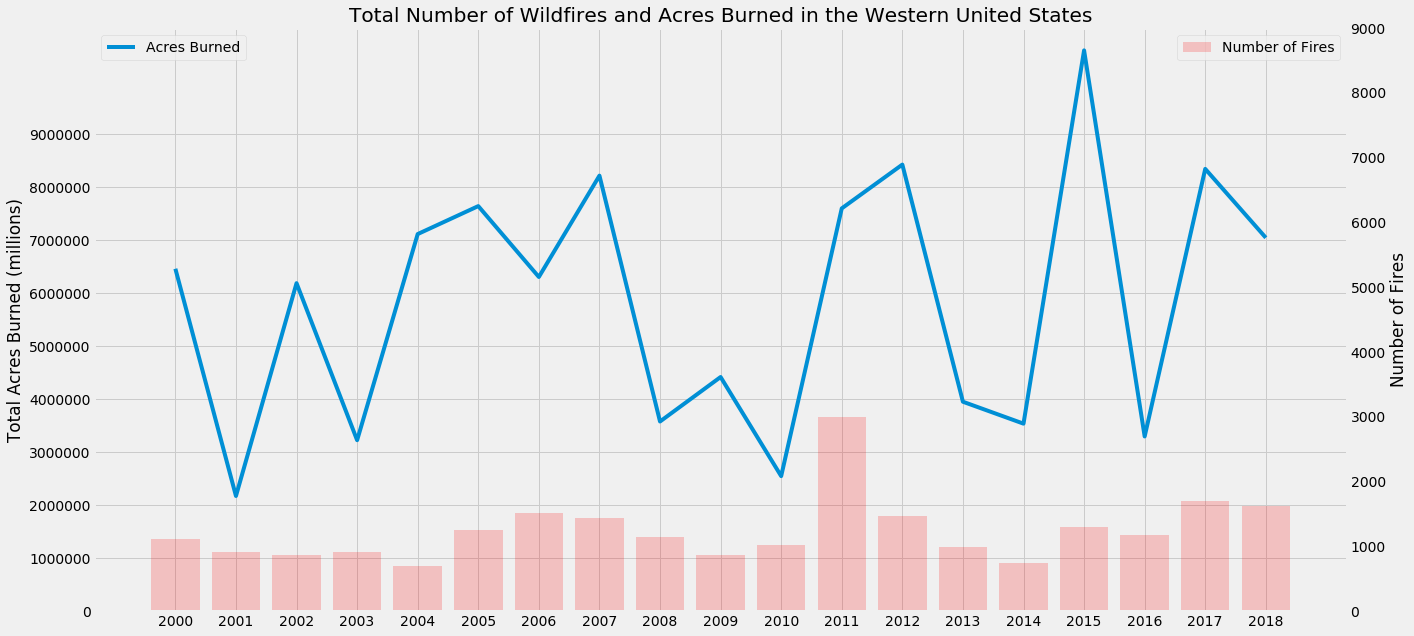

In [174]:

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

ax_2 = ax.twinx()

ax.plot(fire_acres, label = "Acres Burned")
ax.set_yticks(np.arange(0,10000000,1000000))

ax_2.bar(fire_count.index, fire_count, alpha = 0.2, color = 'red', label = "Number of Fires")
ax_2.set_yticks(np.arange(0, 10000, 1000))

ax_2.grid(b = False)

ax.set_title('Total Number of Wildfires and Acres Burned in the Western United States')
ax.set_ylabel('Total Acres Burned (millions)')
ax_2.set_ylabel('Number of Fires')

x_ticks = np.arange(2000, 2019, 1)
plt.xticks(x_ticks)

ax.legend(loc = "upper left")
ax_2.legend()
#plt.savefig("Wildfire_Trends.png")

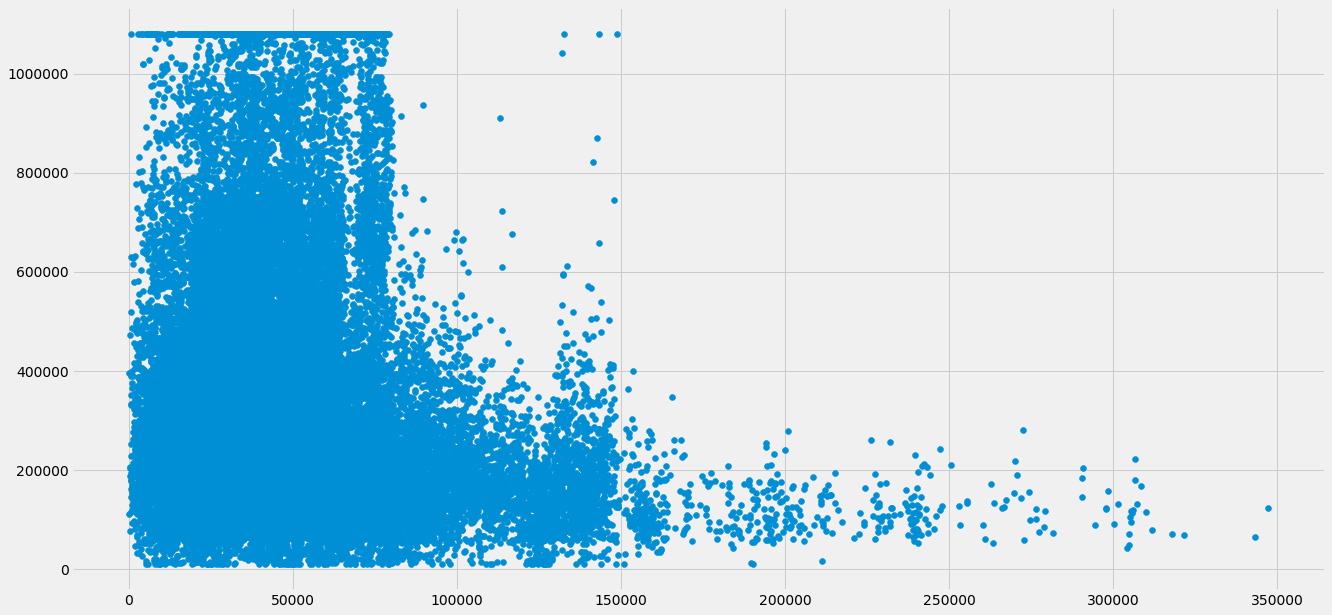

In [163]:
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

ax.scatter(ACS5_2010_2014["min_dist_2015"], ACS5_2010_2014["AL1HE001"] )



In [164]:
import seaborn as sns
from sklearn.neighbors import KernelDensity

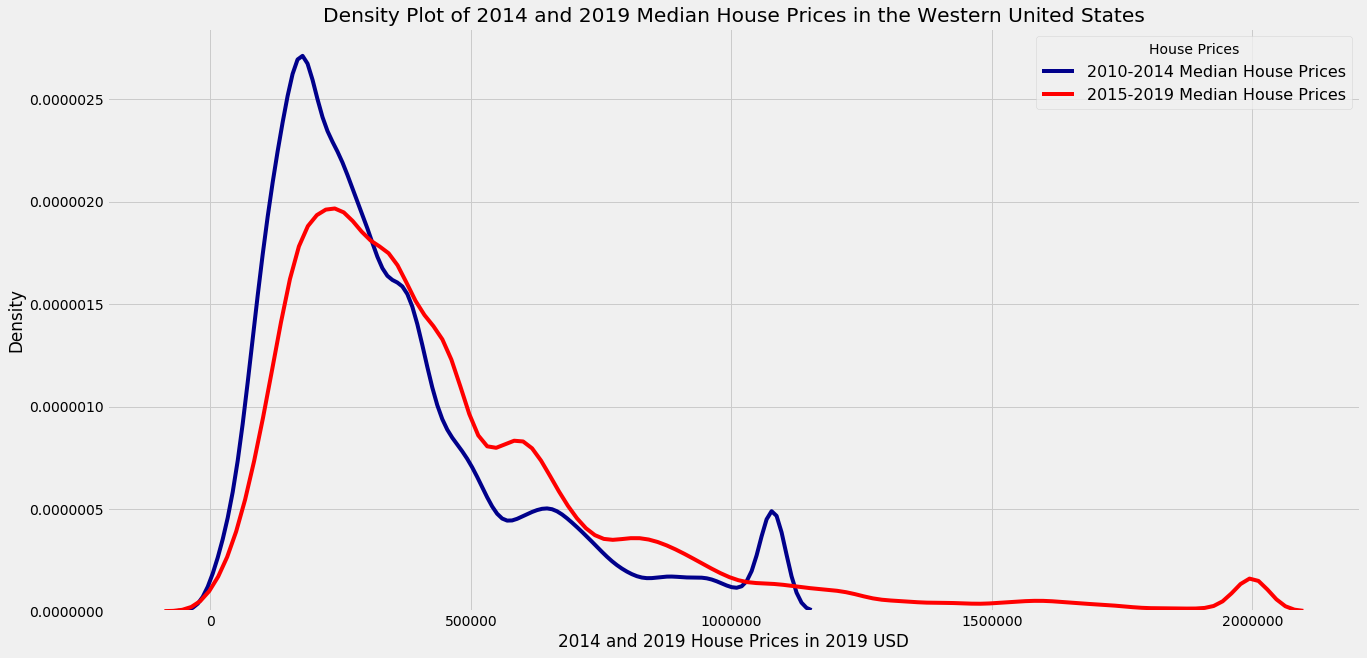

In [172]:
#density plot of house prices 2010-2014 versus 2015-2019
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
sns.distplot(ACS5_2010_2014["AL1HE001"], hist=False, kde=kde,
             bins=int(160/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label = "2010-2014 Median House Prices")

sns.distplot(ACS5_2015_2019["AL1HE001"], hist=False, kde=kde, 
             bins=int(160/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label = "2015-2019 Median House Prices")

plt.legend(prop={'size': 16}, title = 'House Prices')
plt.title('Density Plot of 2014 and 2019 Median House Prices in the Western United States')
plt.xlabel('2014 and 2019 House Prices in 2019 USD')
plt.ylabel('Density')
#plt.savefig("Density_Plot_House_Prices.png")

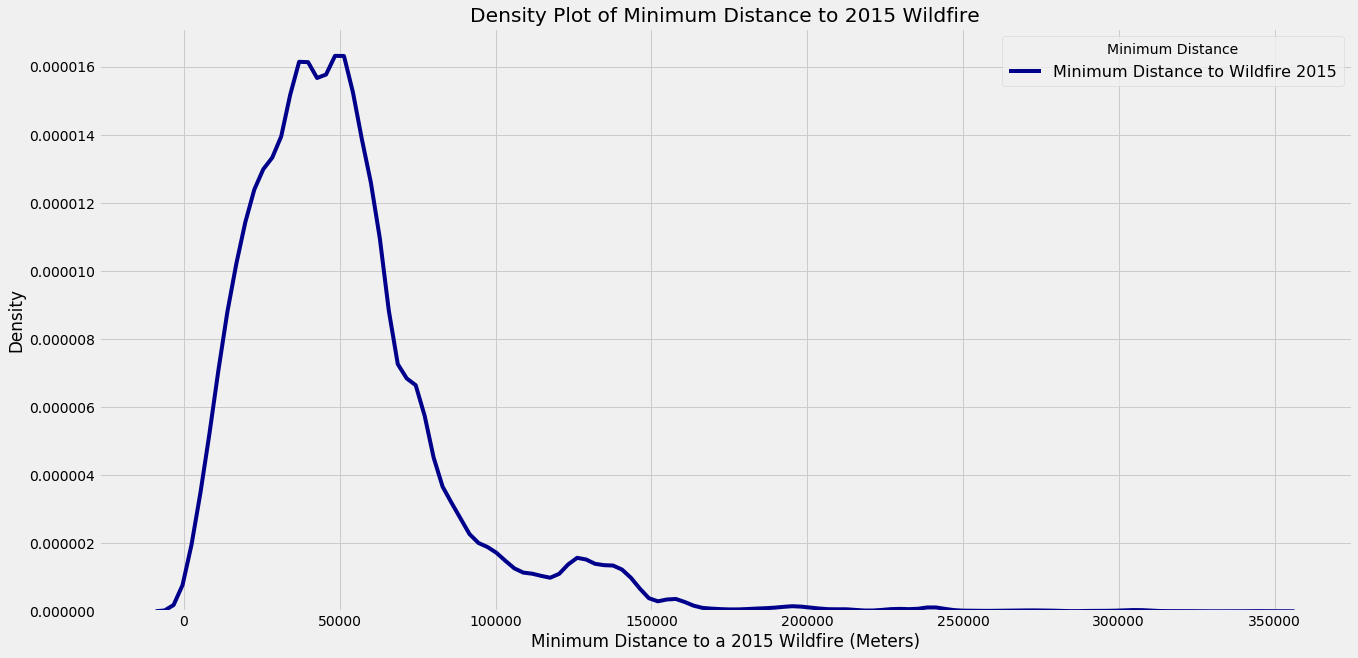

In [173]:
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
sns.distplot(ACS5_2010_2014["min_dist_2015"], hist=False, kde=kde,
             bins=int(160/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label = "Minimum Distance to Wildfire 2015")

plt.legend(prop={'size': 16}, title = 'Minimum Distance')
plt.title('Density Plot of Minimum Distance to 2015 Wildfire')
plt.xlabel('Minimum Distance to a 2015 Wildfire (Meters)')
plt.ylabel('Density')
#plt.savefig("Density_Min_Distance_Fire.png")

In [167]:
fire_state_count = wildfire_perimeters.groupby(["state"]).sum()

In [168]:
fire_state_count = fire_state_count[(fire_state_count.index == "CA") | (fire_state_count.index == "CO") | (fire_state_count.index == "AZ") | (fire_state_count.index == "ID") | (fire_state_count.index == "MT") | (fire_state_count.index == "NV") | (fire_state_count.index == "NM") | (fire_state_count.index == "OR")| (fire_state_count.index == "UT") | (fire_state_count.index == "WA") | (fire_state_count.index == "WY")]

In [169]:
fire_state_count

FID  fireyear      gisacres  SHAPE_Leng  SHAPE_Area  Count
state                                                                 
AZ     12632793   2194116  4.515734e+06  178.168541    1.781682   1091
CA     63367026   9027184  1.378151e+07  590.035585    5.715556   4496
CO     10868981   1915432  1.795533e+06  126.154405    0.755100    953
ID     40824729   6682281  1.278241e+07  620.664086    5.807122   3326
MT     14705177   2623808  7.437857e+06  318.825226    3.534179   1305
NM      9147688   1601334  3.496169e+06  141.595738    1.377073    797
NV     20444304   3500294  8.217136e+06  313.811500    3.532866   1742
OR     21056168   3275116  9.621693e+06  371.339709    4.354435   1630
UT     17809436   2692660  3.226662e+06  171.313191    1.365767   1341
WA      8178479   1412450  5.448106e+06  236.080360    2.644804    702
WY     11966608   2352652  2.052253e+06  151.505470    0.923766   1170

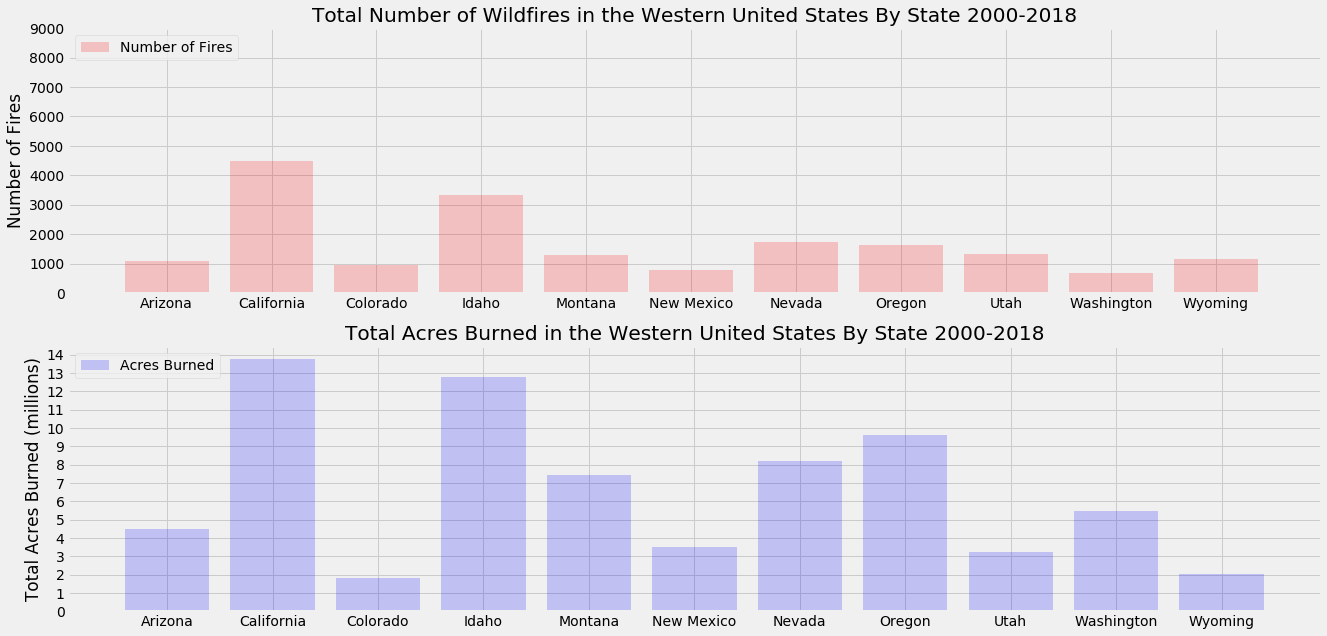

In [170]:
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

fig, (ax_1, ax_2) = plt.subplots(2,1, figsize = (20,10))

#ax_2 = ax.twinx()

# ax.bar(fire_state_count.index, fire_state_count["gisacres"], label = "Acres Burned")
# ax.set_yticks(np.arange(0,10000000,1000000))

ax_1.bar(fire_state_count.index, fire_state_count["Count"], alpha = 0.2, color = 'red', label = "Number of Fires")
ax_1.set_yticks(np.arange(0, 10000, 1000))
# x_ticks = np.arange(0, 24, 1)
# ax_2.set_xticks(x_ticks)


ax_2.bar(fire_state_count.index, fire_state_count["gisacres"], alpha = 0.2, color = 'blue', label = "Acres Burned")
ax_2.set_yticks(np.arange(0,15000000,1000000))
ax_2.set_yticklabels(list(range(0,16)))


ax_1.grid(b = True)

ax_1.set_title('Total Number of Wildfires in the Western United States By State 2000-2018')
ax_2.set_title('Total Acres Burned in the Western United States By State 2000-2018')
ax_2.set_ylabel('Total Acres Burned (millions)')
ax_1.set_ylabel('Number of Fires')

x_ticks = np.arange(0, 12, 1)
ax_1.set_xticks(x_ticks)
ax_1.set_xticklabels(["Arizona", "California", "Colorado","Idaho","Montana", "New Mexico","Nevada","Oregon","Utah", "Washington", "Wyoming"])
ax_2.set_xticklabels(["Arizona", "California", "Colorado","Idaho","Montana", "New Mexico","Nevada","Oregon","Utah", "Washington", "Wyoming"])

ax_1.legend(loc = "upper left")
ax_2.legend(loc = "upper left")
#plt.savefig('fire_by_state.png')

In [ ]:
# fire_count = wildfire_perimeters.groupby(["fireyear"]).count()
# fire_acres = wildfire_perimeters.groupby(["fireyear"]).sum()

In [ ]:
# fire_count["weight_by_acres"] = (fire_count["Count"]*fire_acres["gisacres"])

In [ ]:
# fire_count

In [ ]:

# plt.rcParams['figure.figsize'] = (20,10)
# plt.style.use('fivethirtyeight')

# fig, ax = plt.subplots()

# #ax_2 = ax.twinx()

# ax.plot(fire_count.weight_by_acres, label = "Number of Fires Weighted By Acres")

# #ax_2.bar(fire_acres.index, fire_acres, alpha = 0.2, color = 'red', label = "Acres Burned")

# ax_2.grid(b = False)

# ax.set_title('Total Number of Wildfires and Acres Burned in the Western United States')
# ax.set_ylabel('Number of Fires Weighted By Acres')
# #ax_2.set_ylabel('Total Acres Burned')

# x_ticks = np.arange(2000, 2018, 1)
# plt.xticks(x_ticks)

# ax.legend(loc = "upper left")
# #ax_2.legend()


In [ ]:
# wildfire_perimeters_CA = wildfire_perimeters[wildfire_perimeters["state"]=="CA"]
# wildfire_perimeters_CA["Count"] = 1
# fire_count_CA = wildfire_perimeters_CA.groupby(["fireyear"]).count()
# fire_acres_CA = wildfire_perimeters_CA.groupby(["fireyear"]).sum()
# fire_count_CA = fire_count_CA["Count"]
# fire_acres_CA = fire_acres_CA["gisacres"]

# plt.rcParams['figure.figsize'] = (20,10)
# plt.style.use('fivethirtyeight')

# fig, ax = plt.subplots()

# ax_2 = ax.twinx()

# ax.plot(fire_count_CA, label = "Number of Fires")

# ax_2.bar(fire_acres_CA.index, fire_acres_CA, alpha = 0.2, color = 'red', label = "Acres Burned")

# ax_2.grid(b = False)

# ax.set_title('Total Number of Wildfires and Acres Burned in California')
# ax.set_ylabel('Number of Fires')
# ax_2.set_ylabel('Total Acres Burned')

# x_ticks = np.arange(2000, 2018, 1)
# plt.xticks(x_ticks)

# ax.legend(loc = "upper left")
# ax_2.legend()


In [185]:
3.450397e+05

345039.7

In [186]:
 4.556317e+05

455631.7

In [187]:
3.544493e+05

354449.3

In [188]:
5.770297e+05

577029.7

In [189]:
2.632294e+05

263229.4

In [190]:
 4.389570e+05

438957.0

In [191]:
(577029.7-438957)/438957

0.3145472107746316

In [192]:
(354449.3-263229.4)/263229.4

0.34654145775509865